In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
from cartopy.util import add_cyclic_point

# import regionmask

import seaborn as sns

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

# Import Ngl with pyn_env active 
# import Ngl

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')



## Read in data

**58L**

**New Control:** Update from previous control case - this one turns off the option to use cold air outbreak mods and includes instantaneous output every 6 hours

In [2]:
## Read in new control case (instantaneous data)
caseName   = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_noColdAir_instOutput.001'
scratchDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'

L58fv_ctrlInst_noCold_h2 = xr.open_dataset(scratchDir+caseName+'.cam.h2.001_windVars.nc', decode_times=True)
print('Done with getting special case')

## Add a few shorthand variables 
L58fv_ctrlInst_noCold_h2['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L58fv_ctrlInst_noCold_h2['UBOT'].values**2 + L58fv_ctrlInst_noCold_h2['VBOT'].values**2) )
L58fv_ctrlInst_noCold_h2['windSpeedBot'].attrs['units']   = "m/s"


L58fv_ctrlInst_noCold_h2['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L58fv_ctrlInst_noCold_h2['windSpeedBot'].values - L58fv_ctrlInst_noCold_h2['U10'].values)
L58fv_ctrlInst_noCold_h2['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done with getting special case


In [3]:
## Read in new control case (daily mean data)

L58fv_ctrlInst_noCold_h1 = xr.open_dataset(scratchDir+caseName+'.cam.h1.001_windVars.nc', decode_times=True)
print('Done with getting special case')

## Add a few shorthand variables 
L58fv_ctrlInst_noCold_h1['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L58fv_ctrlInst_noCold_h1['U'].isel(lev=-1).values**2 + L58fv_ctrlInst_noCold_h1['V'].isel(lev=-1).values**2) )
L58fv_ctrlInst_noCold_h1['windSpeedBot'].attrs['units']   = "m/s"


L58fv_ctrlInst_noCold_h1['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L58fv_ctrlInst_noCold_h1['windSpeedBot'].values - L58fv_ctrlInst_noCold_h1['U10'].values)
L58fv_ctrlInst_noCold_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done with getting special case


**Previous control:** 58L, fv, cam6phys as above. But don't have instantaneous output (only daily mean) and cold air outbreak code is active.

In [4]:
## Read in previous 'control' (daily mean, cold air outbreak on)
caseName   = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L.001'
scratchDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'

L58fv_prevCtrl_h1 = xr.open_dataset(scratchDir+caseName+'.cam.h1.001_windVars.nc', decode_times=True)
print('Done with getting special case')

## Add a few shorthand variables 
L58fv_prevCtrl_h1['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L58fv_prevCtrl_h1['U'].isel(lev=-1).values**2 + L58fv_prevCtrl_h1['V'].isel(lev=-1).values**2) )
L58fv_prevCtrl_h1['windSpeedBot'].attrs['units']   = "m/s"


L58fv_prevCtrl_h1['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L58fv_prevCtrl_h1['windSpeedBot'].values - L58fv_prevCtrl_h1['U10'].values)
L58fv_prevCtrl_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done with getting special case


**Test case:** Similar to new control, but U10 as output is the stability adjusted version of U10 not U10n.

In [5]:
## Read in new case that doesn't iterate over U10 (still u10n) but outputs it 
caseName   = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_outputAdjustedU10.003'

scratchDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'
L58fv_outAdjustU10_noCold_h2 = xr.open_dataset(scratchDir+caseName+'.cam.h2.001_windVars.nc', decode_times=True)
L58fv_outAdjustU10_noCold_h1 = xr.open_dataset(scratchDir+caseName+'.cam.h1.001_1dVars.nc', decode_times=True)

print('Done with getting special case')

L58fv_outAdjustU10_noCold_h2['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L58fv_outAdjustU10_noCold_h2['UBOT'].values**2 + L58fv_outAdjustU10_noCold_h2['VBOT'].values**2) )
L58fv_outAdjustU10_noCold_h2['windSpeedBot'].attrs['units']   = "m/s"


L58fv_outAdjustU10_noCold_h2['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L58fv_outAdjustU10_noCold_h2['windSpeedBot'].values - L58fv_outAdjustU10_noCold_h2['U10'].values)
L58fv_outAdjustU10_noCold_h2['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done with getting special case


**Another test case:** This test uses the UA algorithm to compute surface fluxes and U10. Again this is instantaneous output every 6 hours and cold air outbreak code is turned off. 

In [6]:
## Read in new control case (instantaneous data)
caseName   = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L.useUA_instOutput.tryV3.002'
scratchDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'

L58fvUA_ctrlInst_noCold_h2 = xr.open_dataset(scratchDir+caseName+'.cam.h2.001_windVars.nc', decode_times=True)
print('Done with getting special case')

## Add a few shorthand variables 
L58fvUA_ctrlInst_noCold_h2['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L58fvUA_ctrlInst_noCold_h2['UBOT'].values**2 + L58fvUA_ctrlInst_noCold_h2['VBOT'].values**2) )
L58fvUA_ctrlInst_noCold_h2['windSpeedBot'].attrs['units']   = "m/s"


L58fvUA_ctrlInst_noCold_h2['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L58fvUA_ctrlInst_noCold_h2['windSpeedBot'].values - L58fvUA_ctrlInst_noCold_h2['U10'].values)
L58fvUA_ctrlInst_noCold_h2['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done with getting special case


**32L**

In [7]:
## Read in new control case (instantaneous data)
caseName   = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_32L_noColdAir_instOutput.001'
scratchDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'

L32fv_ctrlInst_noCold_h2 = xr.open_dataset(scratchDir+caseName+'.cam.h2.001_windVars.nc', decode_times=True)
print('Done with getting special case')

## Add a few shorthand variables 
L32fv_ctrlInst_noCold_h2['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L32fv_ctrlInst_noCold_h2['UBOT'].values**2 + L32fv_ctrlInst_noCold_h2['VBOT'].values**2) )
L32fv_ctrlInst_noCold_h2['windSpeedBot'].attrs['units']   = "m/s"


L32fv_ctrlInst_noCold_h2['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L32fv_ctrlInst_noCold_h2['windSpeedBot'].values - L32fv_ctrlInst_noCold_h2['U10'].values)
L32fv_ctrlInst_noCold_h2['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done with getting special case


In [8]:
## Read in new case that doesn't iterate over U10 (still u10n) but outputs it 
caseName   = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_32L_outputAdjustedU10.003'

scratchDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'
L32fv_outAdjustU10_noCold_h2 = xr.open_dataset(scratchDir+caseName+'.cam.h2.001_windVars.nc', decode_times=True)
L32fv_outAdjustU10_noCold_h1 = xr.open_dataset(scratchDir+caseName+'.cam.h1.001_1dVars.nc', decode_times=True)

print('Done with getting special case')

L32fv_outAdjustU10_noCold_h2['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L32fv_outAdjustU10_noCold_h2['UBOT'].values**2 + L32fv_outAdjustU10_noCold_h2['VBOT'].values**2) )
L32fv_outAdjustU10_noCold_h2['windSpeedBot'].attrs['units']   = "m/s"


L32fv_outAdjustU10_noCold_h2['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L32fv_outAdjustU10_noCold_h2['windSpeedBot'].values - L32fv_outAdjustU10_noCold_h2['U10'].values)
L32fv_outAdjustU10_noCold_h2['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done with getting special case


## Select JJA to start

In [9]:
## Past Ctrl case
iTimes_sel1    = np.where( (L58fv_prevCtrl_h1['time.month'].values>=6) & (L58fv_prevCtrl_h1['time.month'].values<=8) )[0]
oldCtrl_h1_JJA = L58fv_prevCtrl_h1.isel(time=iTimes_sel1)

## New Ctrl case
iTimes_sel2    = np.where( (L58fv_ctrlInst_noCold_h1['time.month'].values>=6) & (L58fv_ctrlInst_noCold_h1['time.month'].values<=8) )[0]
newCtrl_h1_JJA = L58fv_ctrlInst_noCold_h1.isel(time=iTimes_sel2)

iTimes_sel3    = np.where( (L58fv_ctrlInst_noCold_h2['time.month'].values>=6) & (L58fv_ctrlInst_noCold_h2['time.month'].values<=8) )[0]
newCtrl_h2_JJA = L58fv_ctrlInst_noCold_h2.isel(time=iTimes_sel3)

## Output U10 not U10n 
iTimes_sel4    = np.where( (L58fv_outAdjustU10_noCold_h2['time.month'].values>=6) & (L58fv_outAdjustU10_noCold_h2['time.month'].values<=8) )[0]
newTest_h2_JJA = L58fv_outAdjustU10_noCold_h2.isel(time=iTimes_sel4)

iTimes_sel4    = np.where( (L58fv_outAdjustU10_noCold_h1['time.month'].values>=6) & (L58fv_outAdjustU10_noCold_h1['time.month'].values<=8) )[0]
newTest_h1_JJA = L58fv_outAdjustU10_noCold_h1.isel(time=iTimes_sel4)

## Use UA algorithm
iTimes_sel5    = np.where( (L58fvUA_ctrlInst_noCold_h2['time.month'].values>=6) & (L58fvUA_ctrlInst_noCold_h2['time.month'].values<=8) )[0]
uaCtrl_h2_JJA  = L58fvUA_ctrlInst_noCold_h2.isel(time=iTimes_sel5)

## ---- 32L 
iTimes_sel4    = np.where( (L32fv_ctrlInst_noCold_h2['time.month'].values>=6) & (L32fv_ctrlInst_noCold_h2['time.month'].values<=8) )[0]
newCtrl_32L_h2_JJA = L32fv_ctrlInst_noCold_h2.isel(time=iTimes_sel4)

iTimes_sel4    = np.where( (L32fv_outAdjustU10_noCold_h2['time.month'].values>=6) & (L32fv_outAdjustU10_noCold_h2['time.month'].values<=8) )[0]
newTest_32L_h2_JJA = L32fv_outAdjustU10_noCold_h2.isel(time=iTimes_sel4)

iTimes_sel5    = np.where( (L32fv_outAdjustU10_noCold_h1['time.month'].values>=6) & (L32fv_outAdjustU10_noCold_h1['time.month'].values<=8) )[0]
newTest_32L_h1_JJA = L32fv_outAdjustU10_noCold_h1.isel(time=iTimes_sel5)



In [45]:
np.unique(L32fv_outAdjustU10_noCold_h1['time.year'])

array([1, 2])

In [46]:
np.unique(L58fv_outAdjustU10_noCold_h1['time.year'])

array([1, 2])

In [10]:
print('               Mean windSpeedBot - U10')
print('              -------------------------')
print('Old ctrl (h1, coldAir on): %16.3f' % oldCtrl_h1_JJA.windSpeedBot_minU10.values.mean() )
print('New ctrl (h1, noColdAir):  %16.3f' %  newCtrl_h1_JJA.windSpeedBot_minU10.values.mean() )
print('New ctrl (h2, noColdAir):  %16.3f' %  newCtrl_h2_JJA.windSpeedBot_minU10.values.mean() )
print('New test (h2 output U10 not U10n):  %7.3f' %  newTest_h2_JJA.windSpeedBot_minU10.values.mean() )
print('UA ctrl  (h2, noColdAir):  %16.3f' %  uaCtrl_h2_JJA.windSpeedBot_minU10.values.mean() )

print('   32L   ')
print('New ctrl (h2, noColdAir):  %16.3f' %  newCtrl_32L_h2_JJA.windSpeedBot_minU10.values.mean() )
print('New test (h2 output U10 not U10n):  %7.3f' %  newTest_32L_h2_JJA.windSpeedBot_minU10.values.mean() )



               Mean windSpeedBot - U10
              -------------------------
Old ctrl (h1, coldAir on):           -0.026
New ctrl (h1, noColdAir):            -0.008
New ctrl (h2, noColdAir):             0.398
New test (h2 output U10 not U10n):    0.488
UA ctrl  (h2, noColdAir):             0.489
   32L   
New ctrl (h2, noColdAir):             1.220
New test (h2 output U10 not U10n):    1.323


Using instantaneous output probably *does* matter for this a fair amount...

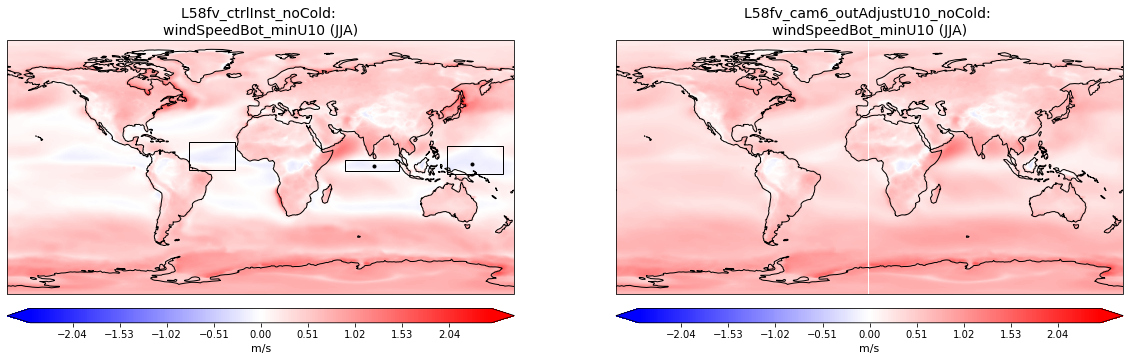

In [11]:
levsMap = np.arange(-2.5,2.51,0.01)
pltVar  = 'windSpeedBot_minU10' 

fig,axs = plt.subplots(1,2, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

## L58fv_ctrlInst_noCold_h1_mean
cplot = axs[0].contourf(newCtrl_h2_JJA.lon.values, newCtrl_h2_JJA.lat.values,
                np.squeeze(newCtrl_h2_JJA[pltVar].mean(dim='time').values), 
                levsMap, cmap='bwr', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58fv_ctrlInst_noCold: \n'+pltVar+' (JJA)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.04])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2[pltVar].units,fontsize=11)

axs[0].plot(80, 1, 'ko', markersize=3, transform=ccrs.PlateCarree())
axs[0].plot(150, 2, 'ko', markersize=3, transform=ccrs.PlateCarree())



## L58fv_outAdjustU10_noCold_h1
cplot = axs[1].contourf(newTest_h2_JJA.lon.values, newTest_h2_JJA.lat.values,
                np.squeeze(newTest_h2_JJA[pltVar].mean(dim='time').values), 
                levsMap, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58fv_cam6_outAdjustU10_noCold: \n'+pltVar+' (JJA)',fontsize=14)

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.04])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2[pltVar].units,fontsize=11)


## Add rectangles? 
axs[0].add_patch(patches.Rectangle(xy=[60, -3], width=38, height=8,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()) )

axs[0].add_patch(patches.Rectangle(xy=[132, -5], width=40, height=20,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()) )

axs[0].add_patch(patches.Rectangle(xy=[309, -2], width=33, height=20,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()) )


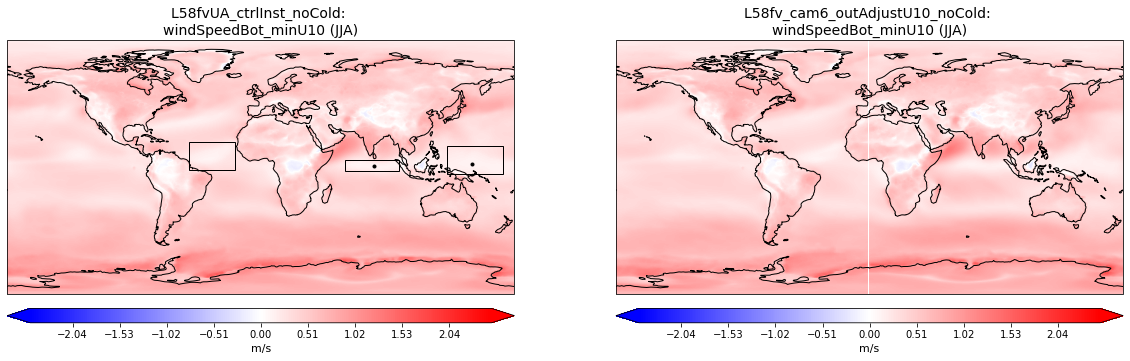

In [13]:
levsMap = np.arange(-2.5,2.51,0.01)
pltVar  = 'windSpeedBot_minU10' 

fig,axs = plt.subplots(1,2, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

## L58fvUA_ctrlInst_noCold_h1_mean
cplot = axs[0].contourf(uaCtrl_h2_JJA.lon.values, uaCtrl_h2_JJA.lat.values,
                np.squeeze(uaCtrl_h2_JJA[pltVar].mean(dim='time').values), 
                levsMap, cmap='bwr', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58fvUA_ctrlInst_noCold: \n'+pltVar+' (JJA)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.04])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fvUA_ctrlInst_noCold_h2[pltVar].units,fontsize=11)

axs[0].plot(80, 1, 'ko', markersize=3, transform=ccrs.PlateCarree())
axs[0].plot(150, 2, 'ko', markersize=3, transform=ccrs.PlateCarree())



## L58fv_outAdjustU10_noCold_h1
cplot = axs[1].contourf(newTest_h2_JJA.lon.values, newTest_h2_JJA.lat.values,
                np.squeeze(newTest_h2_JJA[pltVar].mean(dim='time').values), 
                levsMap, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58fv_cam6_outAdjustU10_noCold: \n'+pltVar+' (JJA)',fontsize=14)

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.04])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2[pltVar].units,fontsize=11)


## Add rectangles? 
axs[0].add_patch(patches.Rectangle(xy=[60, -3], width=38, height=8,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()) )

axs[0].add_patch(patches.Rectangle(xy=[132, -5], width=40, height=20,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()) )

axs[0].add_patch(patches.Rectangle(xy=[309, -2], width=33, height=20,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()) )


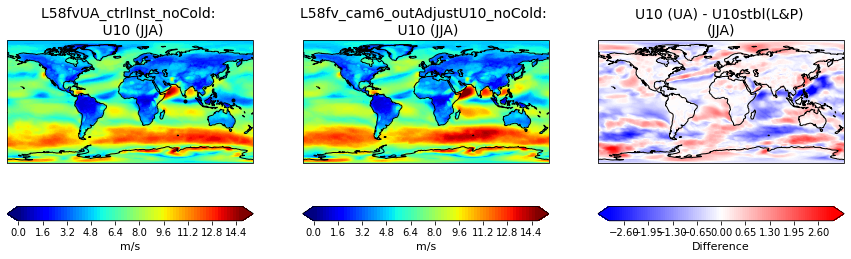

In [17]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,15,0.2)

## L58fvUA_ctrlInst_noCold_h1_mean
cplot = axs[0].contourf(uaCtrl_h2_JJA.lon.values, uaCtrl_h2_JJA.lat.values,
                np.squeeze(uaCtrl_h2_JJA['U10'].mean(dim='time').values), 
                levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58fvUA_ctrlInst_noCold: \n U10 (JJA)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fvUA_ctrlInst_noCold_h2['U10'].units,fontsize=11)

axs[0].plot(80, 1, 'ko', markersize=3, transform=ccrs.PlateCarree())
axs[0].plot(150, 2, 'ko', markersize=3, transform=ccrs.PlateCarree())



## L58fv_outAdjustU10_noCold_h1
cplot = axs[1].contourf(newTest_h2_JJA.lon.values, newTest_h2_JJA.lat.values,
                np.squeeze(newTest_h2_JJA['U10'].mean(dim='time').values), 
                levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58fv_cam6_outAdjustU10_noCold: \n U10 (JJA)',fontsize=14)

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2['U10'].units,fontsize=11)


## Plot diff 
levsDiff = np.arange(-3,3.05,0.05)
cplot = axs[2].contourf(uaCtrl_h2_JJA.lon.values, uaCtrl_h2_JJA.lat.values,
                np.squeeze(uaCtrl_h2_JJA['U10'].mean(dim='time').values - 
                           newTest_h2_JJA['U10'].mean(dim='time').values), 
                levsDiff, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('U10 (UA) - U10stbl(L&P) \n(JJA)',fontsize=14)

# ## Plot PERCENT diff 
# levsDiff = np.arange(-15,16,1)
# cplot = axs[2].contourf(newTest_h2_JJA.lon.values, newTest_h2_JJA.lat.values,
#                 np.squeeze(newTest_h2_JJA['U10'].mean(dim='time').values - 
#                            newCtrl_h2_JJA['U10'].mean(dim='time').values)/
#                 np.squeeze(newCtrl_h2_JJA['U10'].mean(dim='time').values)*100, 
#                     levsDiff, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

# # Add coastline, set title
# axs[2].coastlines()
# axs[2].set_title('L58fv_cam6 U10stab - U10n (JJA)',fontsize=14)


## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(L58fv_ctrlInst_noCold_h2['U10'].units,fontsize=11)
cbar.set_label('Difference',fontsize=11)


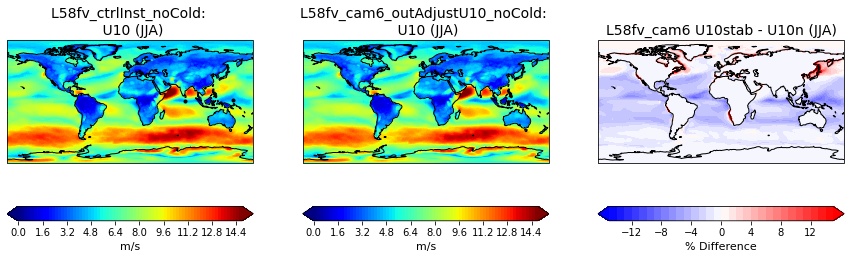

In [55]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,15,0.2)

## L58fv_ctrlInst_noCold_h1_mean
cplot = axs[0].contourf(newCtrl_h2_JJA.lon.values, newCtrl_h2_JJA.lat.values,
                np.squeeze(newCtrl_h2_JJA['U10'].mean(dim='time').values), 
                levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58fv_ctrlInst_noCold: \n U10 (JJA)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2['U10'].units,fontsize=11)

axs[0].plot(80, 1, 'ko', markersize=3, transform=ccrs.PlateCarree())
axs[0].plot(150, 2, 'ko', markersize=3, transform=ccrs.PlateCarree())



## L58fv_outAdjustU10_noCold_h1
cplot = axs[1].contourf(newTest_h2_JJA.lon.values, newTest_h2_JJA.lat.values,
                np.squeeze(newTest_h2_JJA['U10'].mean(dim='time').values), 
                levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58fv_cam6_outAdjustU10_noCold: \n U10 (JJA)',fontsize=14)

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2['U10'].units,fontsize=11)


# ## Plot diff 
# levsDiff = np.arange(-1,1.05,0.05)
# cplot = axs[2].contourf(newTest_h2_JJA.lon.values, newTest_h2_JJA.lat.values,
#                 np.squeeze(newTest_h2_JJA['U10'].mean(dim='time').values - 
#                            newCtrl_h2_JJA['U10'].mean(dim='time').values), 
#                 levsDiff, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

# # Add coastline, set title
# axs[2].coastlines()
# axs[2].set_title('L58fv_cam6 U10stab - U10n (JJA)',fontsize=14)

## Plot PERCENT diff 
levsDiff = np.arange(-15,16,1)
cplot = axs[2].contourf(newTest_h2_JJA.lon.values, newTest_h2_JJA.lat.values,
                np.squeeze(newTest_h2_JJA['U10'].mean(dim='time').values - 
                           newCtrl_h2_JJA['U10'].mean(dim='time').values)/
                np.squeeze(newCtrl_h2_JJA['U10'].mean(dim='time').values)*100, 
                    levsDiff, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58fv_cam6 U10stab - U10n (JJA)',fontsize=14)


## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(L58fv_ctrlInst_noCold_h2['U10'].units,fontsize=11)
cbar.set_label('% Difference',fontsize=11)


**32L**

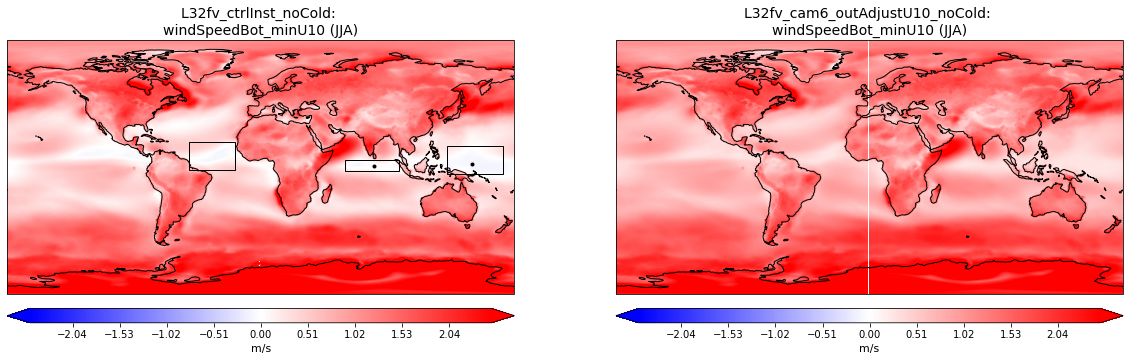

In [85]:
levsMap = np.arange(-2.5,2.51,0.01)
pltVar  = 'windSpeedBot_minU10' 

fig,axs = plt.subplots(1,2, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

## L32fv_ctrlInst_noCold_h1_mean
cplot = axs[0].contourf(newCtrl_32L_h2_JJA.lon.values, newCtrl_32L_h2_JJA.lat.values,
                np.squeeze(newCtrl_32L_h2_JJA[pltVar].mean(dim='time').values), 
                levsMap, cmap='bwr', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32fv_ctrlInst_noCold: \n'+pltVar+' (JJA)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.04])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2[pltVar].units,fontsize=11)

axs[0].plot(80, 1, 'ko', markersize=3, transform=ccrs.PlateCarree())
axs[0].plot(150, 2, 'ko', markersize=3, transform=ccrs.PlateCarree())



## L32fv_outAdjustU10_noCold_h1
cplot = axs[1].contourf(newTest_32L_h2_JJA.lon.values, newTest_32L_h2_JJA.lat.values,
                np.squeeze(newTest_32L_h2_JJA[pltVar].mean(dim='time').values), 
                levsMap, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32fv_cam6_outAdjustU10_noCold: \n'+pltVar+' (JJA)',fontsize=14)

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.04])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2[pltVar].units,fontsize=11)



## Add rectangles? 
axs[0].add_patch(patches.Rectangle(xy=[60, -3], width=38, height=8,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()) )

axs[0].add_patch(patches.Rectangle(xy=[132, -5], width=40, height=20,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()) )

axs[0].add_patch(patches.Rectangle(xy=[309, -2], width=33, height=20,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()) )


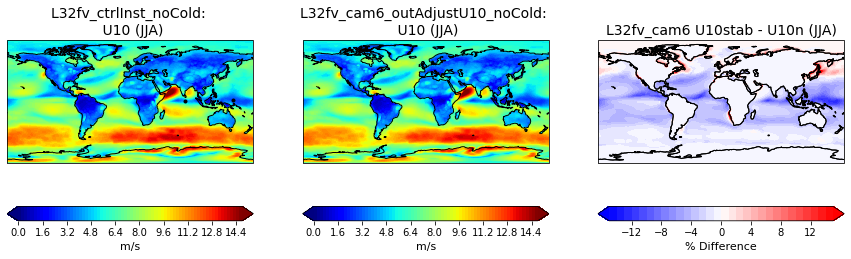

In [56]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,15,0.2)

## L32fv_ctrlInst_noCold_h1_mean
cplot = axs[0].contourf(newCtrl_32L_h2_JJA.lon.values, newCtrl_32L_h2_JJA.lat.values,
                np.squeeze(newCtrl_32L_h2_JJA['U10'].mean(dim='time').values), 
                levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32fv_ctrlInst_noCold: \n U10 (JJA)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2['U10'].units,fontsize=11)

axs[0].plot(80, 1, 'ko', markersize=3, transform=ccrs.PlateCarree())
axs[0].plot(150, 2, 'ko', markersize=3, transform=ccrs.PlateCarree())



## L32fv_outAdjustU10_noCold_h1
cplot = axs[1].contourf(newTest_32L_h2_JJA.lon.values, newTest_32L_h2_JJA.lat.values,
                np.squeeze(newTest_32L_h2_JJA['U10'].mean(dim='time').values), 
                levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32fv_cam6_outAdjustU10_noCold: \n U10 (JJA)',fontsize=14)

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_ctrlInst_noCold_h2['U10'].units,fontsize=11)


# ## Plot diff 
# levsDiff = np.arange(-1,1.05,0.05)
# cplot = axs[2].contourf(newTest_32L_h2_JJA.lon.values, newTest_32L_h2_JJA.lat.values,
#                 np.squeeze(newTest_32L_h2_JJA['U10'].mean(dim='time').values - 
#                            newCtrl_32L_h2_JJA['U10'].mean(dim='time').values), 
#                 levsDiff, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

## Plot PERCENT diff 
levsDiff = np.arange(-15,16,1)
cplot = axs[2].contourf(newTest_32L_h2_JJA.lon.values, newTest_32L_h2_JJA.lat.values,
                np.squeeze(newTest_32L_h2_JJA['U10'].mean(dim='time').values - 
                           newCtrl_32L_h2_JJA['U10'].mean(dim='time').values)/
                np.squeeze(newCtrl_32L_h2_JJA['U10'].mean(dim='time').values)*100, 
                    levsDiff, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58fv_cam6 U10stab - U10n (JJA)',fontsize=14)

# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32fv_cam6 U10stab - U10n (JJA)',fontsize=14)

## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(L58fv_ctrlInst_noCold_h2['U10'].units,fontsize=11)
cbar.set_label('% Difference',fontsize=11)


### Compare to obs?

In [10]:
## A few observational files would be helpful too... 
obsDir = '/glade/p/cesm/amwg/amwg_diagnostics/obs_data/'

erai_jja = xr.open_dataset(obsDir+'ERAI_JJA_climo.nc', decode_times=False)   #PRECT in mm/day 
erai_djf = xr.open_dataset(obsDir+'ERAI_DJF_climo.nc', decode_times=False)   #PRECT in mm/day 


In [11]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [22]:
newTest_32L_h1_JJA['LHFLX']

<xarray.DataArray 'LHFLX' (time: 92, lat: 192, lon: 288)>
[5087232 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0001-06-01 00:00:00 ... 0001-08-31 00:00:00
Attributes:
    units:         W/m2
    long_name:     Surface latent heat flux
    cell_methods:  time: mean

In [12]:
## Get obs grid 
obsGrid = erai_jja.WIND_MAG_SURF.isel(time=0).squeeze()

## Now regrid the data
regrid_L32fv_cam6_h1       = regrid_data(newTest_32L_h1_JJA, obsGrid, method=1).mean(dim='time')
regrid_582fv_cam6_h1       = regrid_data(newTest_h1_JJA, obsGrid, method=1).mean(dim='time')


In [13]:
'''
pltVar:   var to map 
levsMap:  levels to use in contouring raw values 
obsDS:    DS of observations to draw from 
obsName:  Name of variable in obsDS to map
obsLabel: String to use when identifying observational product in title (i.e., 'erai')
minLat,maxLat,minLon,maxLon: Map limits 
'''

def plotBiasMaps(pltVar, levsMap,
                 obsDS, obsName, obsLabel,         
                 minLat, maxLat, minLon, maxLon):
    ## Set up figure 
    fig,axs = plt.subplots(2,3, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    
    fig.delaxes(axs[3])

    # Plot obs in first plot 
    axs[0].contourf(obsDS.lon.values, obsDS.lat.values, np.squeeze(obsDS[obsName].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

    axs[0].coastlines()
    axs[0].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[0].set_title(obsLabel+': '+obsName+' (JJA)', fontsize=14)
    
    varRegrid_L32fv_cam6 = regrid_L32fv_cam6_h1[pltVar]
    varRegrid_L58fv_cam6 = regrid_582fv_cam6_h1[pltVar]
    
         
    ## Plot raw values in model simulations 
    axs[1].contourf(varRegrid_L32fv_cam6.lon.values, varRegrid_L32fv_cam6.lat.values, 
                    np.squeeze(varRegrid_L32fv_cam6.values), levsMap, 
                    cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())
    
    cplot = axs[2].contourf(varRegrid_L58fv_cam6.lon.values, varRegrid_L58fv_cam6.lat.values, 
                    np.squeeze(varRegrid_L58fv_cam6.values), levsMap, 
                    cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())
    
    # Add colorbar
    ax_position = axs[2].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.04, ax_position.width+0.1, 0.03])
    cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(obsDS[obsName].units,fontsize=11)

    
    axs[1].set_title(pltVar+'\nL32_fv_cam6 (noCold_outAdjustU10)')
    axs[2].set_title('L58_fv_cam6 (noCold_outAdjustU10)')

    
    ## Plot biases 
    bias_L32fv_cam6   = np.squeeze(varRegrid_L32fv_cam6.values   - obsDS[obsName].values)
    bias_L58fv_cam6   = np.squeeze(varRegrid_L58fv_cam6.values   - obsDS[obsName].values)
  
    maxDiff  = np.nanpercentile( [bias_L32fv_cam6, bias_L58fv_cam6], 99.9) 
    minDiff  = np.nanpercentile( [bias_L32fv_cam6, bias_L58fv_cam6], 0.1) 
    levEven  = np.nanmax([np.abs(maxDiff), np.abs(minDiff)])
    levsDiff = np.arange(-levEven, levEven+((2*levEven)/100), (2*levEven)/100) 
    
    axs[4].contourf(varRegrid_L32fv_cam6.lon.values, varRegrid_L32fv_cam6.lat.values, 
                    bias_L32fv_cam6, levsDiff, 
                    cmap='bwr', extend='both', transform=ccrs.PlateCarree())
    
    cplot = axs[5].contourf(varRegrid_L58fv_cam6.lon.values, varRegrid_L58fv_cam6.lat.values, 
                    bias_L58fv_cam6, levsDiff, 
                    cmap='bwr', extend='both', transform=ccrs.PlateCarree())
    
     
    # Add colorbar
    ax_position = axs[5].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.04, ax_position.width+0.1, 0.02])
    cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(obsDS[obsName].units,fontsize=11)
    
    
    ## Set up other plotting options (i.e., add coasts, etc.) 
    axs[1].coastlines()
    axs[2].coastlines()
    axs[4].coastlines()
    axs[5].coastlines()

    
    axs[1].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[2].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[4].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[5].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())

    return 

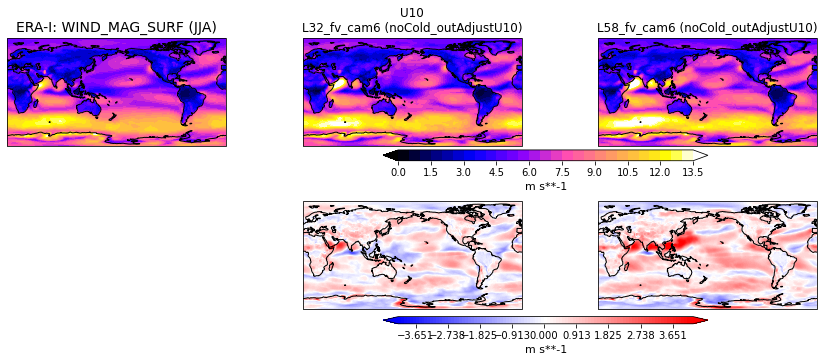

In [14]:
plotBiasMaps('U10', np.arange(0,14,0.5),
             erai_jja, 'WIND_MAG_SURF', 'ERA-I',         
             # 5, 30, 90, 145)
             -89, 89, 0, 359)


### Regional but look at all three months

In [57]:
## 32L
ilon_ATL = np.where((newCtrl_32L_h2_JJA.lon.values>=309) & (newCtrl_32L_h2_JJA.lon.values<=(309+33)))[0]
ilat_ATL = np.where((newCtrl_32L_h2_JJA.lat.values>=-2) & (newCtrl_32L_h2_JJA.lat.values<=(-2+20)))[0]
ATL58_ctrlH2 = newCtrl_h2_JJA.isel(lon=ilon_ATL, lat=ilat_ATL)
ATL32_ctrlH2 = newCtrl_32L_h2_JJA.isel(lon=ilon_ATL, lat=ilat_ATL) 

ilon_IO = np.where((newCtrl_32L_h2_JJA.lon.values>=60) & (newCtrl_32L_h2_JJA.lon.values<=(60+38)))[0]
ilat_IO = np.where((newCtrl_32L_h2_JJA.lat.values>=-3) & (newCtrl_32L_h2_JJA.lat.values<=(-3+8)))[0]
IO58_ctrlH2 = newCtrl_h2_JJA.isel(lon=ilon_IO, lat=ilat_IO)
IO32_ctrlH2 = newCtrl_32L_h2_JJA.isel(lon=ilon_IO, lat=ilat_IO)


ilon_WP = np.where((newCtrl_32L_h2_JJA.lon.values>=132) & (newCtrl_32L_h2_JJA.lon.values<=(132+40)))[0]
ilat_WP = np.where((newCtrl_32L_h2_JJA.lat.values>=-5) & (newCtrl_32L_h2_JJA.lat.values<=(-5+20)))[0]
WP58_ctrlH2 = newCtrl_h2_JJA.isel(lon=ilon_WP, lat=ilat_WP)
WP32_ctrlH2 = newCtrl_32L_h2_JJA.isel(lon=ilon_WP, lat=ilat_WP)


In [64]:
ATL_ocn32    = ocnMask32[ilat_ATL,:] 
ATL_ocn32    = ATL_ocn32[:,ilon_ATL]
ATL_ocn58    = ocnMask58[ilat_ATL,:] 
ATL_ocn58    = ATL_ocn58[:,ilon_ATL]

IO_ocn32    = ocnMask32[ilat_IO,:] 
IO_ocn32    = IO_ocn32[:,ilon_IO]
IO_ocn58    = ocnMask58[ilat_IO,:] 
IO_ocn58    = IO_ocn58[:,ilon_IO]

WP_ocn32    = ocnMask32[ilat_WP,:] 
WP_ocn32    = WP_ocn32[:,ilon_WP]
WP_ocn58    = ocnMask58[ilat_WP,:] 
WP_ocn58    = WP_ocn58[:,ilon_WP]




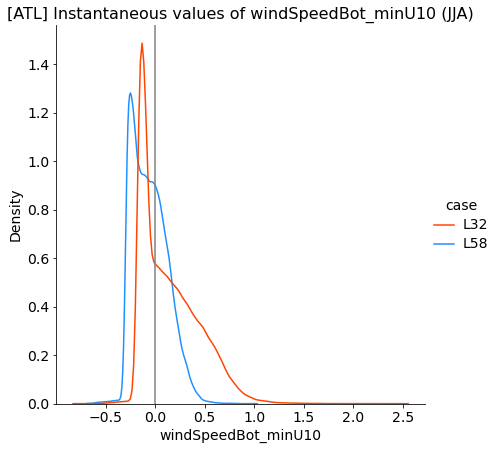

In [60]:
distVar = 'windSpeedBot_minU10'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(ATL32_ctrlH2[distVar].values*ATL_ocn32).reshape([len(ATL32_ctrlH2.lon.values)*len(ATL32_ctrlH2.lat.values)*len(ATL32_ctrlH2.time.values)]), 'case': 'L32'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(ATL58_ctrlH2[distVar].values*ATL_ocn58).reshape([len(ATL58_ctrlH2.lon.values)*len(ATL58_ctrlH2.lat.values)*len(ATL32_ctrlH2.time.values)]), 'case': 'L58'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=6, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[ATL] Instantaneous values of "+distVar+" (JJA)", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)

g.ax.axvline(0, color='grey')



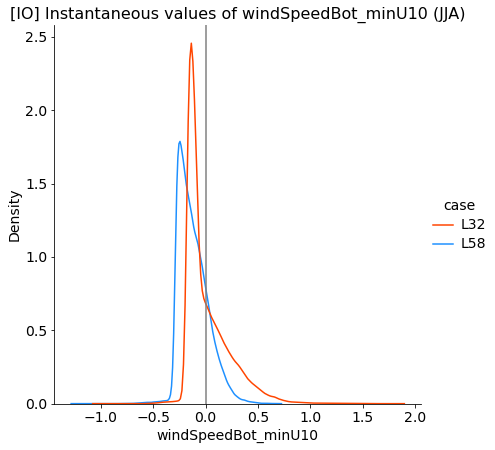

In [62]:
distVar = 'windSpeedBot_minU10'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(IO32_ctrlH2[distVar].values*IO_ocn32).reshape([len(IO32_ctrlH2.lon.values)*len(IO32_ctrlH2.lat.values)*len(IO32_ctrlH2.time.values)]), 'case': 'L32'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(IO58_ctrlH2[distVar].values*IO_ocn58).reshape([len(IO58_ctrlH2.lon.values)*len(IO58_ctrlH2.lat.values)*len(IO58_ctrlH2.time.values)]), 'case': 'L58'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=6, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[IO] Instantaneous values of "+distVar+" (JJA)", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)

g.ax.axvline(0, color='grey')



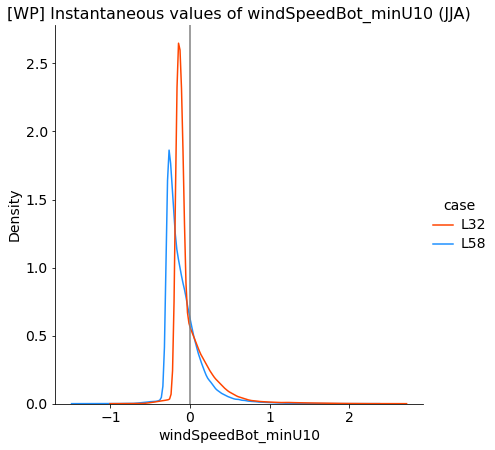

In [65]:
distVar = 'windSpeedBot_minU10'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(WP32_ctrlH2[distVar].values*WP_ocn32).reshape([len(WP32_ctrlH2.lon.values)*len(WP32_ctrlH2.lat.values)*len(WP32_ctrlH2.time.values)]), 'case': 'L32'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(WP58_ctrlH2[distVar].values*WP_ocn58).reshape([len(WP58_ctrlH2.lon.values)*len(WP58_ctrlH2.lat.values)*len(WP58_ctrlH2.time.values)]), 'case': 'L58'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=6, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[WP] Instantaneous values of "+distVar+" (JJA)", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)

g.ax.axvline(0, color='grey')



## Look at just periods in June to dig in more

In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
## Open h1 files: 
scratchDir   = '/glade/scratch/mdfowler/archive/'

testCaseName = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_outputAdjustedU10.003'
testDS_h1    = xr.open_dataset(scratchDir+testCaseName+'/atm/hist/'+testCaseName+'.cam.h1.0001-06-05-00000.nc', decode_times=True)

ctrlCaseName = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_noColdAir_instOutput.001'
ctrlDS_h1    = xr.open_dataset(scratchDir+ctrlCaseName+'/atm/hist/'+ctrlCaseName+'.cam.h1.0001-06-05-00000.nc', decode_times=True)

testDS_h1['windSpeedBot'] = (('time','lat','lon'), np.sqrt(testDS_h1['U'].isel(lev=-1).values**2 +
                                                           testDS_h1['V'].isel(lev=-1).values**2)  )
ctrlDS_h1['windSpeedBot'] = (('time','lat','lon'), np.sqrt(ctrlDS_h1['U'].isel(lev=-1).values**2 +
                                                           ctrlDS_h1['V'].isel(lev=-1).values**2)  )

In [4]:
## Open h2 files: 
scratchDir   = '/glade/scratch/mdfowler/archive/'

testCaseName = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_outputAdjustedU10.003'
testDS_h2    = xr.open_dataset(scratchDir+testCaseName+'/atm/hist/'+testCaseName+'.cam.h2.0001-06-05-00000.nc', decode_times=True)

ctrlCaseName = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_noColdAir_instOutput.001'
ctrlDS_h2    = xr.open_dataset(scratchDir+ctrlCaseName+'/atm/hist/'+ctrlCaseName+'.cam.h2.0001-06-05-00000.nc', decode_times=True)

testDS_h2['windSpeedBot'] = (('time','lat','lon'), np.sqrt(testDS_h2['UBOT'].values**2 +
                                                           testDS_h2['VBOT'].values**2)  )
ctrlDS_h2['windSpeedBot'] = (('time','lat','lon'), np.sqrt(ctrlDS_h2['UBOT'].values**2 +
                                                           ctrlDS_h2['VBOT'].values**2)  )

In [5]:
testDS_h1 = cesm_correct_time(testDS_h1)
ctrlDS_h1 = cesm_correct_time(ctrlDS_h1)
testDS_h2 = cesm_correct_time(testDS_h2)
ctrlDS_h2 = cesm_correct_time(ctrlDS_h2)


In [6]:
## 32L ctrl case? 
## Open h2 files: 
scratchDir   = '/glade/scratch/mdfowler/archive/'

testCaseName32 = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_32L_outputAdjustedU10.003'
testDS32_h2    = xr.open_dataset(scratchDir+testCaseName32+'/atm/hist/'+testCaseName32+'.cam.h2.0001-06-05-00000.nc', decode_times=True)

ctrlCaseName32 = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_32L_noColdAir_instOutput.001'
ctrlDS32_h2    = xr.open_dataset(scratchDir+ctrlCaseName32+'/atm/hist/'+ctrlCaseName32+'.cam.h2.0001-06-05-00000.nc', decode_times=True)

testDS32_h2['windSpeedBot'] = (('time','lat','lon'), np.sqrt(testDS32_h2['UBOT'].values**2 +
                                                             testDS32_h2['VBOT'].values**2)  )
ctrlDS32_h2['windSpeedBot'] = (('time','lat','lon'), np.sqrt(ctrlDS32_h2['UBOT'].values**2 +
                                                             ctrlDS32_h2['VBOT'].values**2)  )

testDS32_h2 = cesm_correct_time(testDS32_h2)
ctrlDS32_h2 = cesm_correct_time(ctrlDS32_h2)



**Get variables from offline shr_flux_mod calc**

In [7]:
## Also open files with output from NCL "offline" calculation [follows ctrl case]
saveDir = '/glade/work/mdfowler/gust_cam7/Analysis/'

## These files output the u10n with cold air off
testFile32 = saveDir+'F2010climo.f09_f09_mg17.TestGustGlobal_Control_32L_noColdAir_instOutput.001.stabilityInfo_coldAirOff.nc'
testFile58 = saveDir+'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_noColdAir_instOutput.001.stabilityInfo_coldAirOff.nc'

L32ds = xr.open_dataset(testFile32, decode_times=True)
L58ds = xr.open_dataset(testFile58, decode_times=True)

L32ds['rd_ov_rdn'] = (('time','lat','lon'), L32ds['rd'].values/L32ds['rdn'].values)
L58ds['rd_ov_rdn'] = (('time','lat','lon'), L58ds['rd'].values/L58ds['rdn'].values)

## The value for 'hol' written out is adjusted to work for 2m calculations of T/Q, we want the hol value before that
L32ds['hol_corrected'] = (('time','lat','lon'), L32ds['hol'].values*ctrlDS32_h2['ZBOT'].values/2.0)
L58ds['hol_corrected'] = (('time','lat','lon'), L58ds['hol'].values*ctrlDS_h2['ZBOT'].values/2.0)



In [8]:
## Also read in ocean frac:
dataDir = '/glade/work/mdfowler/gust_cam7/output/'
# dataDir = '/project/amp/mdfowler/gust/output/'

h0File       = dataDir+'F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h0.0002-01.nc'
ofrac32      = xr.open_dataset(h0File, decode_times=True).isel(time=0)['OCNFRAC']
ocnMask32             = np.ones([len(L32ds.lat.values),len(L32ds.lon.values)])
ocnMask32[ofrac32==0] = np.nan

h0File58    = dataDir+'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L.001.cam.h0.0002-01.nc'
ofrac58     = xr.open_dataset(h0File58, decode_times=True).isel(time=0)['OCNFRAC']
ocnMask58             = np.ones([len(L58ds.lat.values),len(L58ds.lon.values)])
ocnMask58[ofrac58==0] = np.nan



**Quick sanity check: U10 same?**

In [9]:
## Get difference, averaged over time 
diff32 = np.nanmean(L32ds['u10n'].values - ctrlDS32_h2['U10'].values, axis=0)
diff58 = np.nanmean(L58ds['u10n'].values - ctrlDS_h2['U10'].values, axis=0)


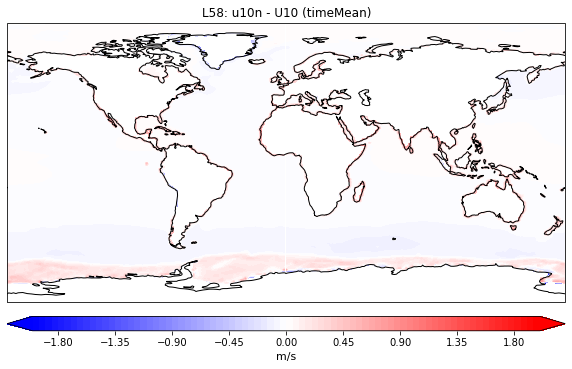

In [10]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

cplot = axs.contourf(L58ds.lon.values, L58ds.lat.values, 
            ocnMask58*np.squeeze(diff58), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58: u10n - U10 (timeMean)',fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)



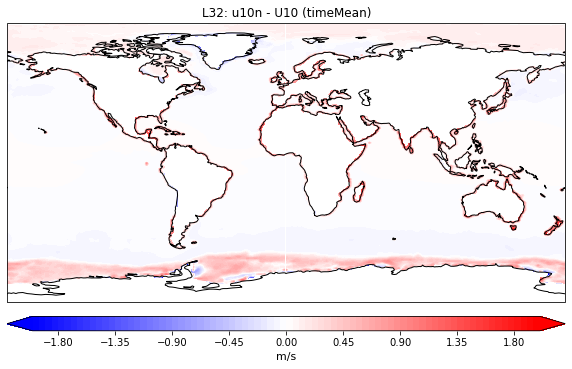

In [11]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

cplot = axs.contourf(L32ds.lon.values, L32ds.lat.values, 
            ocnMask32*np.squeeze(diff32), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L32: u10n - U10 (timeMean)',fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)



#### Look at individual points

In [6]:
## Sel Ind Ocean point
lonSel = 80
latSel = 1

IOpoint_test   = testDS_h1.sel(lon=lonSel, lat=latSel, method='nearest') 
IOpoint_ctrl   = ctrlDS_h1.sel(lon=lonSel, lat=latSel, method='nearest') 

IOpoint_testH2 = testDS_h2.sel(lon=lonSel, lat=latSel, method='nearest')
IOpoint_ctrlH2 = ctrlDS_h2.sel(lon=lonSel, lat=latSel, method='nearest')

## Sel West Pac point
lonSelWP = 150
latSelWP = 2

WPpoint_test   = testDS_h1.sel(lon=lonSelWP, lat=latSelWP, method='nearest') 
WPpoint_ctrl   = ctrlDS_h1.sel(lon=lonSelWP, lat=latSelWP, method='nearest') 

WPpoint_testH2 = testDS_h2.sel(lon=lonSelWP, lat=latSelWP, method='nearest')
WPpoint_ctrlH2 = ctrlDS_h2.sel(lon=lonSelWP, lat=latSelWP, method='nearest')


Start date:  0001-06-05 15:00:00
End date:  0001-06-07 21:00:00


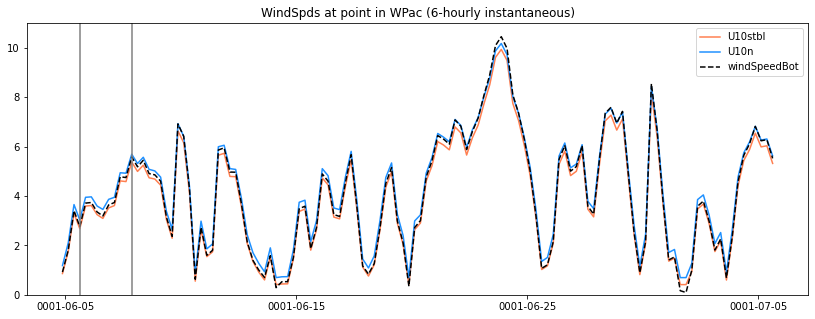

In [7]:
fig,axs = plt.subplots(1,1, figsize=(14,5))

axs.plot(WPpoint_testH2.time.values, WPpoint_testH2.U10.values, color='coral', label='U10stbl')
axs.plot(WPpoint_ctrlH2.time.values, WPpoint_ctrlH2.U10.values, color='dodgerblue', label='U10n')
axs.plot(WPpoint_ctrlH2.time.values, WPpoint_ctrlH2.windSpeedBot.values, 'k--', label='windSpeedBot')

axs.legend()

axs.set_ylim([0,11])
axs.set_title('WindSpds at point in WPac (6-hourly instantaneous)')

axs.axvline(WPpoint_testH2.time.values[3],color='grey')
axs.axvline(WPpoint_testH2.time.values[12],color='grey')

print('Start date: ',WPpoint_testH2.time.values[3])
print('End date: ',WPpoint_testH2.time.values[12])

Text(0.5, 1.0, 'WindSpds at point in WPac (daily means, not instantaneous)')

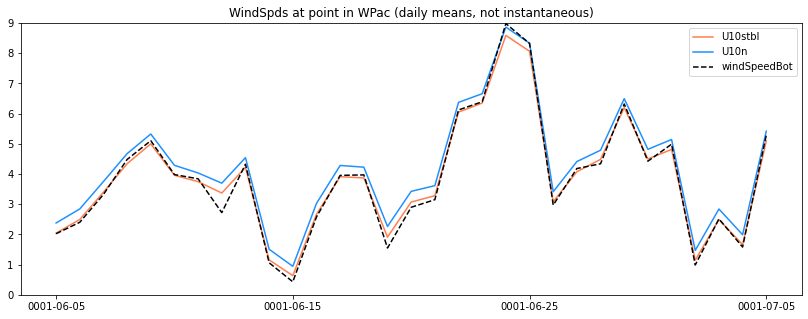

In [31]:
fig,axs = plt.subplots(1,1, figsize=(14,5))

axs.plot(WPpoint_test.time.values, WPpoint_test.U10.values, color='coral', label='U10stbl')
axs.plot(WPpoint_ctrl.time.values, WPpoint_ctrl.U10.values, color='dodgerblue', label='U10n')
axs.plot(WPpoint_ctrl.time.values, WPpoint_ctrl.windSpeedBot.values, 'k--', label='windSpeedBot')

axs.legend()

# axs.set_xlim([selPoint_U10stbl.time.values[630], selPoint_U10stbl.time.values[680]])
axs.set_ylim([0,9])
axs.set_title('WindSpds at point in WPac (daily means, not instantaneous)')


**Plot daily mean variables (from h1)**

Start date:  0001-06-05 18:00:00
End date:  0001-06-08 00:00:00


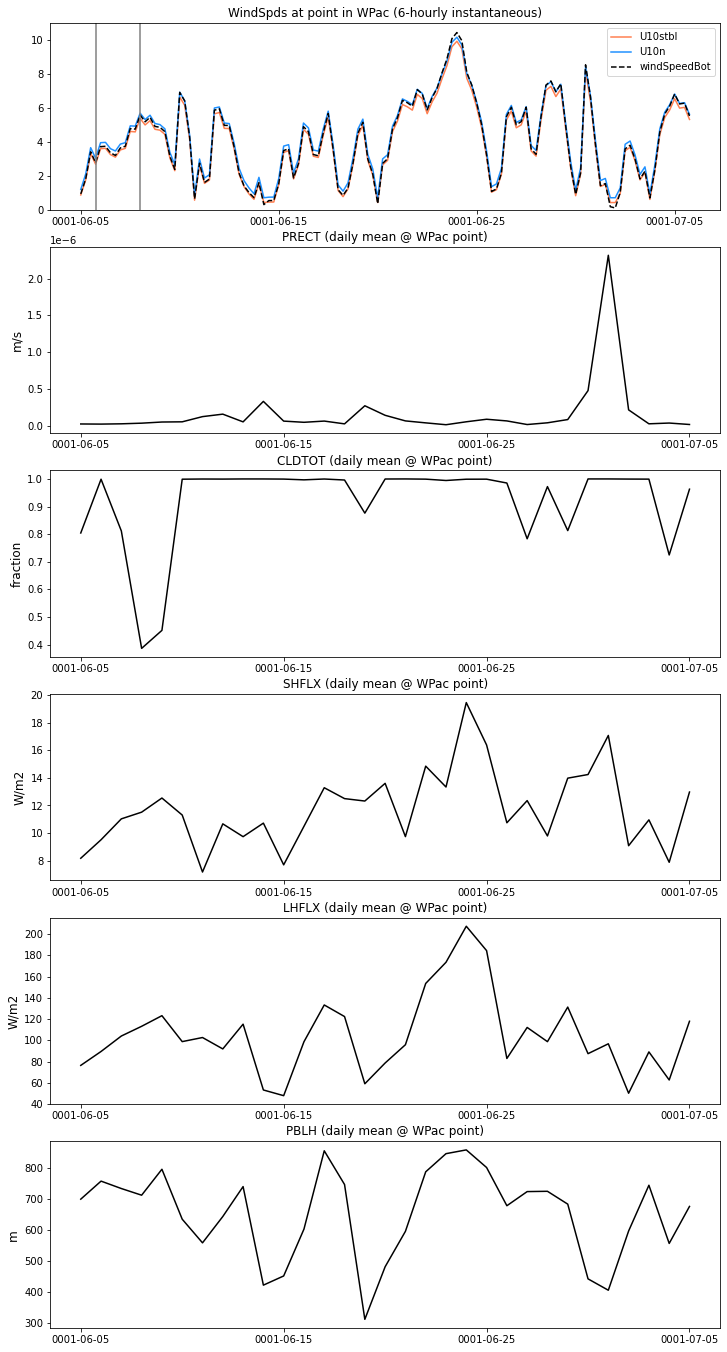

In [18]:

plotVars = ['PRECT','CLDTOT','SHFLX','LHFLX','PBLH']

fig,axs = plt.subplots(len(plotVars)+1,1, figsize=(12,4*(len(plotVars)+1)))
axs = axs.ravel()

## First plot: inst U10 and windBot
axs[0].plot(WPpoint_testH2.time.values, WPpoint_testH2.U10.values, color='coral', label='U10stbl')
axs[0].plot(WPpoint_ctrlH2.time.values, WPpoint_ctrlH2.U10.values, color='dodgerblue', label='U10n')
axs[0].plot(WPpoint_ctrlH2.time.values, WPpoint_ctrlH2.windSpeedBot.values, 'k--', label='windSpeedBot')
axs[0].legend()
axs[0].set_ylim([0,11])
axs[0].set_title('WindSpds at point in WPac (6-hourly instantaneous)')
axs[0].axvline(WPpoint_testH2.time.values[3],color='grey')
axs[0].axvline(WPpoint_testH2.time.values[12],color='grey')

print('Start date: ',WPpoint_testH2.time.values[3])
print('End date: ',WPpoint_testH2.time.values[12])

for iPlt in range(len(plotVars)): 
    axs[iPlt+1].plot(WPpoint_test.time.values, WPpoint_test[plotVars[iPlt]].values, color='k')
    axs[iPlt+1].set_title(plotVars[iPlt]+' (daily mean @ WPac point)',fontsize=12)
    axs[iPlt+1].set_ylabel(ctrlDS_h1[plotVars[iPlt]].units, fontsize=12)


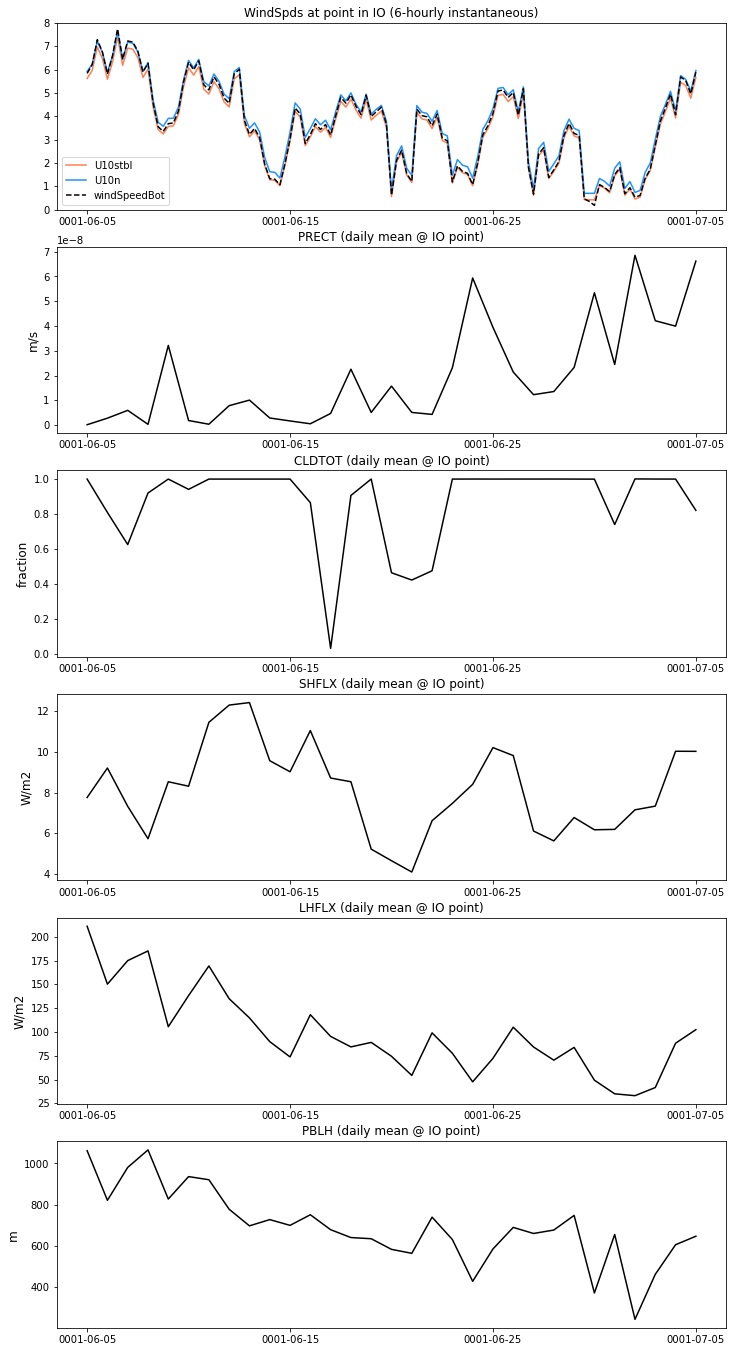

In [14]:

plotVars = ['PRECT','CLDTOT','SHFLX','LHFLX','PBLH']

fig,axs = plt.subplots(len(plotVars)+1,1, figsize=(12,4*(len(plotVars)+1)))
axs = axs.ravel()

## First plot: inst U10 and windBot
axs[0].plot(IOpoint_testH2.time.values, IOpoint_testH2.U10.values, color='coral', label='U10stbl')
axs[0].plot(IOpoint_ctrlH2.time.values, IOpoint_ctrlH2.U10.values, color='dodgerblue', label='U10n')
axs[0].plot(IOpoint_ctrlH2.time.values, IOpoint_ctrlH2.windSpeedBot.values, 'k--', label='windSpeedBot')
axs[0].legend()
axs[0].set_ylim([0,8])
axs[0].set_title('WindSpds at point in IO (6-hourly instantaneous)')

# axs[0].axvline(IOpoint_testH2.time.values[3],color='grey')
# axs[0].axvline(IOpoint_testH2.time.values[12],color='grey')
# print('Start date: ',IOpoint_testH2.time.values[3])
# print('End date: ',IOpoint_testH2.time.values[12])

for iPlt in range(len(plotVars)): 
    axs[iPlt+1].plot(IOpoint_test.time.values, IOpoint_test[plotVars[iPlt]].values, color='k')
    axs[iPlt+1].set_title(plotVars[iPlt]+' (daily mean @ IO point)',fontsize=12)
    axs[iPlt+1].set_ylabel(ctrlDS_h1[plotVars[iPlt]].units, fontsize=12)


**Plot inst variables (from h2)**

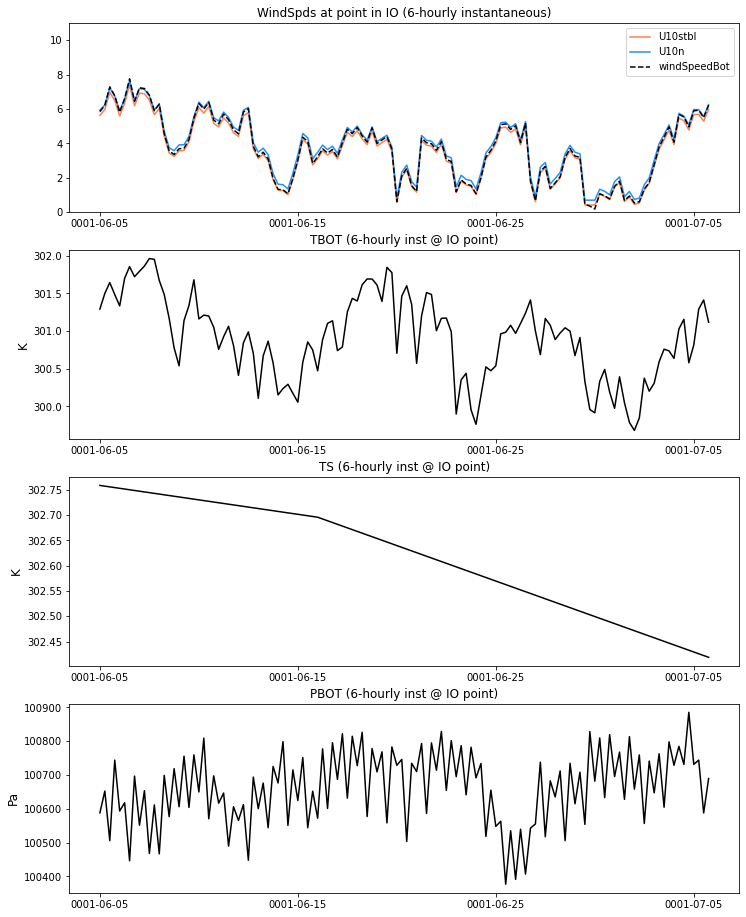

In [20]:

plotVars = ['TBOT','TS','PBOT']

fig,axs = plt.subplots(len(plotVars)+1,1, figsize=(12,4*(len(plotVars)+1)))
axs = axs.ravel()

## First plot: inst U10 and windBot
axs[0].plot(IOpoint_testH2.time.values, IOpoint_testH2.U10.values, color='coral', label='U10stbl')
axs[0].plot(IOpoint_ctrlH2.time.values, IOpoint_ctrlH2.U10.values, color='dodgerblue', label='U10n')
axs[0].plot(IOpoint_ctrlH2.time.values, IOpoint_ctrlH2.windSpeedBot.values, 'k--', label='windSpeedBot')
axs[0].legend()
axs[0].set_ylim([0,11])
axs[0].set_title('WindSpds at point in IO (6-hourly instantaneous)')


for iPlt in range(len(plotVars)): 
    axs[iPlt+1].plot(IOpoint_testH2.time.values, IOpoint_testH2[plotVars[iPlt]].values, color='k')
    axs[iPlt+1].set_title(plotVars[iPlt]+' (6-hourly inst @ IO point)',fontsize=12)
    axs[iPlt+1].set_ylabel(ctrlDS_h2[plotVars[iPlt]].units, fontsize=12)


Start date:  0001-06-05 18:00:00
End date:  0001-06-08 00:00:00


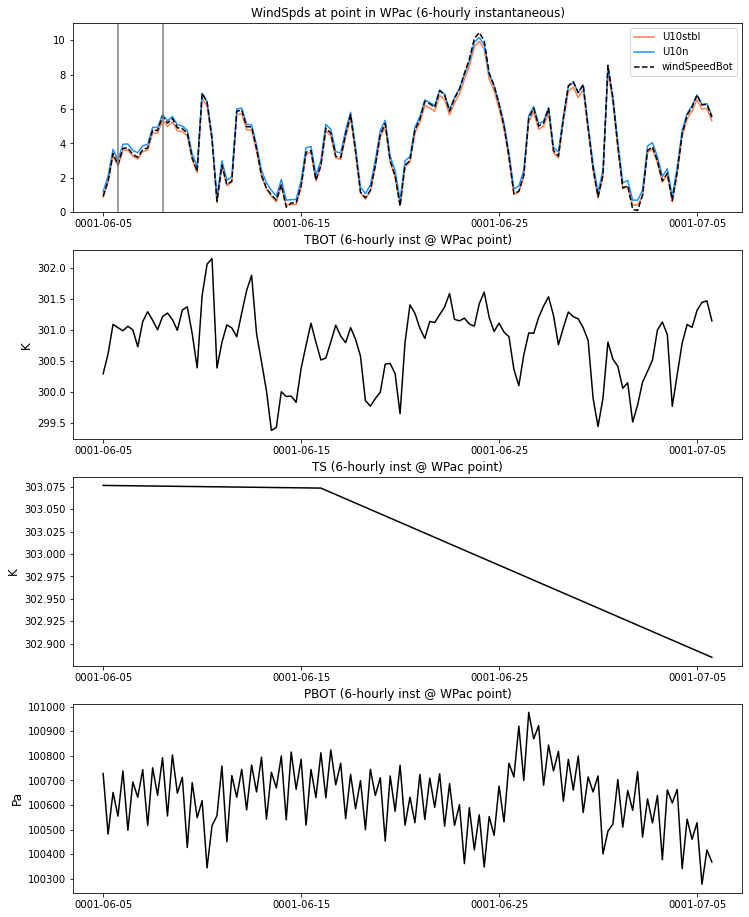

In [20]:

plotVars = ['TBOT','TS','PBOT']

fig,axs = plt.subplots(len(plotVars)+1,1, figsize=(12,4*(len(plotVars)+1)))
axs = axs.ravel()

## First plot: inst U10 and windBot
axs[0].plot(WPpoint_testH2.time.values, WPpoint_testH2.U10.values, color='coral', label='U10stbl')
axs[0].plot(WPpoint_ctrlH2.time.values, WPpoint_ctrlH2.U10.values, color='dodgerblue', label='U10n')
axs[0].plot(WPpoint_ctrlH2.time.values, WPpoint_ctrlH2.windSpeedBot.values, 'k--', label='windSpeedBot')
axs[0].legend()
axs[0].set_ylim([0,11])
axs[0].set_title('WindSpds at point in WPac (6-hourly instantaneous)')
axs[0].axvline(WPpoint_testH2.time.values[3],color='grey')
axs[0].axvline(WPpoint_testH2.time.values[12],color='grey')

print('Start date: ',WPpoint_testH2.time.values[3])
print('End date: ',WPpoint_testH2.time.values[12])

for iPlt in range(len(plotVars)): 
    axs[iPlt+1].plot(WPpoint_testH2.time.values, WPpoint_testH2[plotVars[iPlt]].values, color='k')
    axs[iPlt+1].set_title(plotVars[iPlt]+' (6-hourly inst @ WPac point)',fontsize=12)
    axs[iPlt+1].set_ylabel(ctrlDS_h2[plotVars[iPlt]].units, fontsize=12)


**What if we look just at the times where this happens?**

**West Pacific point...**

In [8]:
print('CTRL case')

iTimes       = np.where( WPpoint_ctrlH2.U10.values > WPpoint_ctrlH2.windSpeedBot.values )[0] 
iTimesStrict = np.where( WPpoint_ctrlH2.U10.values > (WPpoint_ctrlH2.windSpeedBot.values*1.1) )[0] 

print('Number of timesteps where U10>windBot:       %i (%2.2f pct of all days)' % (len(iTimes),
                                                                            (len(iTimes)/len(WPpoint_ctrlH2.time.values))*100) )
print('Number of timesteps where U10>windBot*1.1:   %i (%2.2f pct of all days)' % (len(iTimesStrict),
                                                                            (len(iTimesStrict)/len(WPpoint_ctrlH2.time.values))*100) )

iTimesGood       = np.where( WPpoint_ctrlH2.U10.values <= WPpoint_ctrlH2.windSpeedBot.values )[0] 
print('Number of timesteps where U10 <= windBot:       %i (%2.2f pct of all days)' % (len(iTimesGood),
                                                                            (len(iTimesGood)/len(WPpoint_ctrlH2.time.values))*100) )



CTRL case
Number of timesteps where U10>windBot:       113 (91.13 pct of all days)
Number of timesteps where U10>windBot*1.1:   38 (30.65 pct of all days)
Number of timesteps where U10 <= windBot:       11 (8.87 pct of all days)


In [54]:
# print('Test case')

# iTimes       = np.where( WPpoint_testH2.U10.values > WPpoint_testH2.windSpeedBot.values )[0] 
# iTimesStrict = np.where( WPpoint_testH2.U10.values > (WPpoint_testH2.windSpeedBot.values*1.1) )[0] 

# print('Number of timesteps where U10>windBot:       %i (%2.2f pct of all days)' % (len(iTimes),
#                                                                             (len(iTimes)/len(WPpoint_testH2.time.values))*100) )
# print('Number of timesteps where U10>windBot*1.1:   %i (%2.2f pct of all days)' % (len(iTimesStrict),
#                                                                             (len(iTimesStrict)/len(WPpoint_testH2.time.values))*100) )


Test case
Number of timesteps where U10>windBot:       4 (3.23 pct of all days)
Number of timesteps where U10>windBot*1.1:   4 (3.23 pct of all days)


In [10]:
## Get times where this isn't so bad... 
restOfTimes         = np.arange(0, len(WPpoint_ctrlH2.time.values))
restOfTimes = np.delete(restOfTimes, iTimes)

restOfTimesStrict         = np.arange(0, len(WPpoint_ctrlH2.time.values))
restOfTimesStrict = np.delete(restOfTimesStrict, iTimesStrict)


In [70]:
# print( len(WPpoint_ctrlH2.time.values))
# print(len(iTimesStrict))
# print(len(restOfTimesStrict))
# print(len(restOfTimesStrict)+len(iTimesStrict))


124
38
86
124


In [11]:
probTimesStrict_WP_ctrlH2 = WPpoint_ctrlH2.isel(time=iTimesStrict)
probTimes_WP_ctrlH2       = WPpoint_ctrlH2.isel(time=iTimes)

restTimesStrict_WP_ctrlH2 = WPpoint_ctrlH2.isel(time=restOfTimesStrict)
restTimes_WP_ctrlH2       = WPpoint_ctrlH2.isel(time=restOfTimes)

goodTimes_WP_ctrlH2       = WPpoint_ctrlH2.isel(time=iTimesGood)


In [12]:
varMeans = np.asarray(['PBOT','LHFLX','SHFLX','TAUX','TAUY','U10','windSpeedBot','TBOT','QBOT'])

mean_probTimesStrict_WP_ctrlH2 = probTimesStrict_WP_ctrlH2.mean(dim='time')
mean_probTimes_WP_ctrlH2       = probTimes_WP_ctrlH2.mean(dim='time')
mean_restTimesStrict_WP_ctrlH2 = WPpoint_ctrlH2.isel(time=restOfTimesStrict).mean(dim='time')
mean_restTimes_WP_ctrlH2       = WPpoint_ctrlH2.isel(time=restOfTimes).mean(dim='time')

print('                 Mean values over groups of timesteps....')
print('                         strict                         notStrict')
print('                 probTimes    restTimes            probTimes    restTimes')

for iVar in range(len(varMeans)):
    print('%12s %12.4f %14.4f %18.4f %14.4f' % 
          (varMeans[iVar], 
           mean_probTimesStrict_WP_ctrlH2[varMeans[iVar]].values,  mean_restTimesStrict_WP_ctrlH2[varMeans[iVar]].values,
           mean_probTimes_WP_ctrlH2[varMeans[iVar]].values,  mean_restTimes_WP_ctrlH2[varMeans[iVar]].values) )
    


                 Mean values over groups of timesteps....
                         strict                         notStrict
                 probTimes    restTimes            probTimes    restTimes
        PBOT  100646.3516    100623.0547        100640.0547    100528.8750
       LHFLX      53.6460       128.9458            98.7248       179.2719
       SHFLX       9.3553        12.9325            11.2477        17.8820
        TAUX       0.0031         0.0015             0.0068        -0.0473
        TAUY      -0.0005        -0.0088            -0.0009        -0.0611
         U10       1.6929         5.4300             3.8823         8.4192
windSpeedBot       1.3986         5.3075             3.6794         8.5290
        TBOT     300.1745       301.0784           300.7654       301.1709
        QBOT       0.0200         0.0193             0.0195         0.0197


**I have more variables saved as daily averages, is there something indicative in that set of data?**

In [13]:
fullDay = []

for iTime in range(len(probTimesStrict_WP_ctrlH2.time.values)):
    thisDate = probTimesStrict_WP_ctrlH2.time[iTime]
    
    iMatch = np.where( (probTimesStrict_WP_ctrlH2['time.month'].values==thisDate['time.month'].values) & 
                       (probTimesStrict_WP_ctrlH2['time.day'].values==thisDate['time.day'].values))[0]
    
    if len(iMatch)==4:
        fullDay = np.append(fullDay, thisDate)

print(fullDay)

[cftime.DatetimeNoLeap(1, 6, 13, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 13, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 13, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 13, 21, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 14, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 14, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 14, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 14, 21, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 1, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 1, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 1, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 1, 21, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 3, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 3, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 3, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1,

In [15]:
fullDayGood = []

for iTime in range(len(goodTimes_WP_ctrlH2.time.values)):
    thisDate = goodTimes_WP_ctrlH2.time[iTime]
    
    iMatch = np.where( (goodTimes_WP_ctrlH2['time.month'].values==thisDate['time.month'].values) & 
                       (goodTimes_WP_ctrlH2['time.day'].values==thisDate['time.day'].values))[0]
    
    if len(iMatch)>=3:
        fullDayGood = np.append(fullDayGood, thisDate)

print(fullDayGood)

[cftime.DatetimeNoLeap(1, 6, 23, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 23, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 23, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 23, 21, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 24, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 24, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 24, 15, 0, 0, 0, has_year_zero=True)]


In [25]:
## Match up days: 
monMatch = [ 6, 6,  7,  7]
dayMatch = [13, 14, 1,  3]

probDays = []
for iDay in range(len(monMatch)): 
    iSelDay = np.where((WPpoint_ctrl['time.month']==monMatch[iDay]) & (WPpoint_ctrl['time.day']==dayMatch[iDay]))[0]
    
    probDays = np.append(probDays,iSelDay)
    

probTimesStrict_WP_ctrlH1       = WPpoint_ctrl.isel(time=probDays.astype(int))
mean_probTimesStrict_WP_ctrlH1  = probTimesStrict_WP_ctrlH1.mean(dim='time')


In [31]:
restOfDays = np.arange(0, len(WPpoint_ctrl.time.values))
restOfDays = np.delete(restOfDays, probDays.astype(int))
mean_restTimesStrict_WP_ctrlH1 = WPpoint_ctrl.isel(time=restOfDays.astype(int)).mean(dim='time')

In [26]:
## Match up days: 
monMatchGood = [ 6, 6  ]
dayMatchGood = [23, 24 ]

goodDays = []
for iDay in range(len(monMatchGood)): 
    iSelDay = np.where((WPpoint_ctrl['time.month']==monMatchGood[iDay]) & (WPpoint_ctrl['time.day']==dayMatchGood[iDay]))[0]
    
    goodDays = np.append(goodDays,iSelDay)
    

goodTimesStrict_WP_ctrlH1       = WPpoint_ctrl.isel(time=goodDays.astype(int))
mean_goodTimesStrict_WP_ctrlH1  = goodTimesStrict_WP_ctrlH1.mean(dim='time')


In [58]:
WPpoint_ctrl.FSDS.long_name

'Downwelling solar flux at surface'

In [60]:
varMeans = np.asarray(['LHFLX','SHFLX','U10','windSpeedBot','CLDHGH','CLDLOW','CLDTOT','FLDS','FSNS','FSDS','FLNS','SWCF','LWCF','PBLH','TMQ'])


print('     Mean values over days with (a) all times/day problematic;')
print('                                (b) at least three times/day good ')
print('                                (c) all days not falling into category (a)\n')

print('                 probDays    restDays    goodDays')

for iVar in range(len(varMeans)):
    print('%12s %12.4f %11.4f %11.4f' % 
          (varMeans[iVar], 
           mean_probTimesStrict_WP_ctrlH1[varMeans[iVar]].values, 
           mean_restTimesStrict_WP_ctrlH1[varMeans[iVar]].values,
           mean_goodTimesStrict_WP_ctrlH1[varMeans[iVar]].values) )
    


     Mean values over days with (a) all times/day problematic;
                                (b) at least three times/day good 
                                (c) all days not falling into category (a)

                 probDays    restDays    goodDays
       LHFLX      53.4080    112.5111    196.0476
       SHFLX       8.8538     12.2142     17.9115
         U10       1.4778      4.5896      8.5982
windSpeedBot       1.0151      4.2641      8.6518
      CLDHGH       0.9222      0.8521      0.9991
      CLDLOW       0.1605      0.2016      0.1915
      CLDTOT       0.9309      0.9196      0.9991
        FLDS     434.7185    434.9334    433.6107
        FSNS     154.2844    185.5992    203.6354
        FSDS     162.5847    194.8388    213.5408
        FLNS      43.2156     43.1711     44.3351
        SWCF    -108.5913    -81.4508    -64.8865
        LWCF      73.6261     57.6375     68.1329
        PBLH     506.6667    675.3234    829.4918
         TMQ      57.6839     56.3245     54

In [45]:
varMeans = np.asarray(['PRECT','PRECC','PRECZ'])


print('     Mean values over days with (a) all times/day problematic;')
print('                                (b) at least three times/day good ')
print('                                (c) all days not falling into category (a)\n')

print('                 probDays    restDays    goodDays')

for iVar in range(len(varMeans)):
    print('%12s %12.4e %11.4e %11.4e' % 
          (varMeans[iVar], 
           mean_probTimesStrict_WP_ctrlH1[varMeans[iVar]].values, 
           mean_restTimesStrict_WP_ctrlH1[varMeans[iVar]].values,
           mean_goodTimesStrict_WP_ctrlH1[varMeans[iVar]].values) )
    


     Mean values over days with (a) all times/day problematic;
                                (b) at least three times/day good 
                                (c) all days not falling into category (a)

                 probDays    restDays    goodDays
       PRECT   1.6030e-07  1.6168e-07  6.9720e-08
       PRECC   5.8838e-08  6.6704e-08  6.3916e-08
       PRECZ   5.8838e-08  6.6704e-08  6.3916e-08


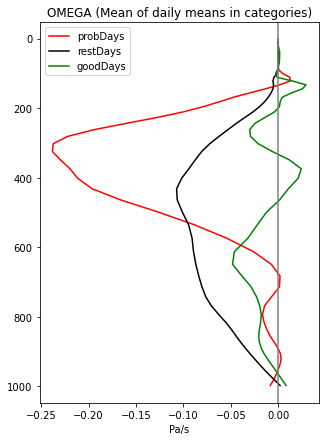

In [53]:
profVar = 'OMEGA'

fig,axs = plt.subplots(1,1, figsize=(5,7))
axs.plot(mean_probTimesStrict_WP_ctrlH1[profVar].values, mean_probTimesStrict_WP_ctrlH1.lev.values, 'r-',label='probDays')
axs.plot(mean_restTimesStrict_WP_ctrlH1[profVar].values, mean_restTimesStrict_WP_ctrlH1.lev.values, 'k-',label='restDays')
axs.plot(mean_goodTimesStrict_WP_ctrlH1[profVar].values, mean_goodTimesStrict_WP_ctrlH1.lev.values, 'g-',label='goodDays')
axs.set_title(profVar+' (Mean of daily means in categories)')
axs.legend()
axs.set_xlabel(WPpoint_ctrl[profVar].units)
axs.invert_yaxis()

axs.axvline(0,color='grey')


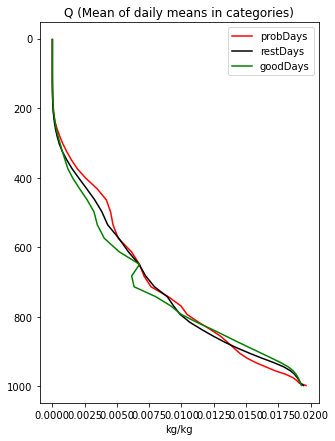

In [56]:
profVar = 'Q'

fig,axs = plt.subplots(1,1, figsize=(5,7))
axs.plot(mean_probTimesStrict_WP_ctrlH1[profVar].values, mean_probTimesStrict_WP_ctrlH1.lev.values, 'r-',label='probDays')
axs.plot(mean_restTimesStrict_WP_ctrlH1[profVar].values, mean_restTimesStrict_WP_ctrlH1.lev.values, 'k-',label='restDays')
axs.plot(mean_goodTimesStrict_WP_ctrlH1[profVar].values, mean_goodTimesStrict_WP_ctrlH1.lev.values, 'g-',label='goodDays')
axs.set_title(profVar+' (Mean of daily means in categories)')
axs.legend()
axs.set_xlabel(WPpoint_ctrl[profVar].units)
axs.invert_yaxis()



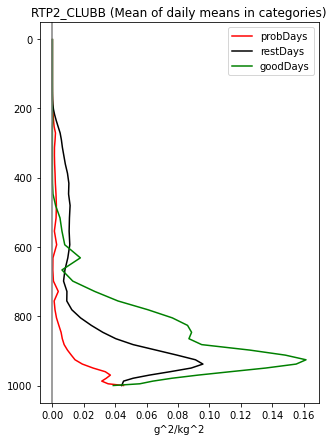

In [73]:
profVar = 'RTP2_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(5,7))
axs.plot(mean_probTimesStrict_WP_ctrlH1[profVar].values, mean_probTimesStrict_WP_ctrlH1.ilev.values, 'r-',label='probDays')
axs.plot(mean_restTimesStrict_WP_ctrlH1[profVar].values, mean_restTimesStrict_WP_ctrlH1.ilev.values, 'k-',label='restDays')
axs.plot(mean_goodTimesStrict_WP_ctrlH1[profVar].values, mean_goodTimesStrict_WP_ctrlH1.ilev.values, 'g-',label='goodDays')
axs.set_title(profVar+' (Mean of daily means in categories)')
axs.legend()
axs.set_xlabel(WPpoint_ctrl[profVar].units)
axs.invert_yaxis()
axs.axvline(0,color='grey')


**Indian Ocean point...**

In [74]:
print('CTRL case')

iTimes       = np.where( IOpoint_ctrlH2.U10.values > IOpoint_ctrlH2.windSpeedBot.values )[0] 
iTimesStrict = np.where( IOpoint_ctrlH2.U10.values > (IOpoint_ctrlH2.windSpeedBot.values*1.1) )[0] 

print('Number of timesteps where U10>windBot:       %i (%2.2f pct of all days)' % (len(iTimes),
                                                                            (len(iTimes)/len(IOpoint_ctrlH2.time.values))*100) )
print('Number of timesteps where U10>windBot*1.1:   %i (%2.2f pct of all days)' % (len(iTimesStrict),
                                                                            (len(iTimesStrict)/len(IOpoint_ctrlH2.time.values))*100) )

iTimesGood       = np.where( IOpoint_ctrlH2.U10.values <= IOpoint_ctrlH2.windSpeedBot.values )[0] 
print('Number of timesteps where U10 <= windBot:       %i (%2.2f pct of all days)' % (len(iTimesGood),
                                                                            (len(iTimesGood)/len(IOpoint_ctrlH2.time.values))*100) )



CTRL case
Number of timesteps where U10>windBot:       116 (93.55 pct of all days)
Number of timesteps where U10>windBot*1.1:   33 (26.61 pct of all days)
Number of timesteps where U10 <= windBot:       8 (6.45 pct of all days)


In [75]:
## Get times where this isn't so bad... 
restOfTimes         = np.arange(0, len(IOpoint_ctrlH2.time.values))
restOfTimes = np.delete(restOfTimes, iTimes)

restOfTimesStrict         = np.arange(0, len(IOpoint_ctrlH2.time.values))
restOfTimesStrict = np.delete(restOfTimesStrict, iTimesStrict)


In [76]:
probTimesStrict_IO_ctrlH2 = IOpoint_ctrlH2.isel(time=iTimesStrict)
probTimes_IO_ctrlH2       = IOpoint_ctrlH2.isel(time=iTimes)

restTimesStrict_IO_ctrlH2 = IOpoint_ctrlH2.isel(time=restOfTimesStrict)
restTimes_IO_ctrlH2       = IOpoint_ctrlH2.isel(time=restOfTimes)

goodTimes_IO_ctrlH2       = IOpoint_ctrlH2.isel(time=iTimesGood)


In [77]:
varMeans = np.asarray(['PBOT','LHFLX','SHFLX','TAUX','TAUY','U10','windSpeedBot','TBOT','QBOT'])

mean_probTimesStrict_IO_ctrlH2 = probTimesStrict_IO_ctrlH2.mean(dim='time')
mean_probTimes_IO_ctrlH2       = probTimes_IO_ctrlH2.mean(dim='time')
mean_restTimesStrict_IO_ctrlH2 = IOpoint_ctrlH2.isel(time=restOfTimesStrict).mean(dim='time')
mean_restTimes_IO_ctrlH2       = IOpoint_ctrlH2.isel(time=restOfTimes).mean(dim='time')

print('                 Mean values over groups of timesteps....')
print('                         strict                         notStrict')
print('                 probTimes    restTimes            probTimes    restTimes')

for iVar in range(len(varMeans)):
    print('%12s %12.4f %14.4f %18.4f %14.4f' % 
          (varMeans[iVar], 
           mean_probTimesStrict_IO_ctrlH2[varMeans[iVar]].values,  mean_restTimesStrict_IO_ctrlH2[varMeans[iVar]].values,
           mean_probTimes_IO_ctrlH2[varMeans[iVar]].values,  mean_restTimes_IO_ctrlH2[varMeans[iVar]].values) )
    


                 Mean values over groups of timesteps....
                         strict                         notStrict
                 probTimes    restTimes            probTimes    restTimes
        PBOT  100698.3594    100648.5469        100667.0703    100585.4688
       LHFLX      47.8051       113.6011            90.6195       175.4263
       SHFLX       6.7272         8.6359             8.1930         7.1849
        TAUX      -0.0009        -0.0084            -0.0027        -0.0598
        TAUY      -0.0021        -0.0183            -0.0150         0.0010
         U10       1.5043         4.7295             3.6576         6.9681
windSpeedBot       1.2365         4.5960             3.4737         7.0111
        TBOT     300.3485       301.1119           300.8505       301.7538
        QBOT       0.0198         0.0188             0.0192         0.0181


In [79]:
fullDay = []

for iTime in range(len(probTimesStrict_IO_ctrlH2.time.values)):
    thisDate = probTimesStrict_IO_ctrlH2.time[iTime]
    
    iMatch = np.where( (probTimesStrict_IO_ctrlH2['time.month'].values==thisDate['time.month'].values) & 
                       (probTimesStrict_IO_ctrlH2['time.day'].values==thisDate['time.day'].values))[0]
    
    if len(iMatch)==4:
        fullDay = np.append(fullDay, thisDate)

print(fullDay)

[cftime.DatetimeNoLeap(1, 6, 23, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 23, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 23, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 23, 21, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 30, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 30, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 30, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 30, 21, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 1, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 1, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 1, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 7, 1, 21, 0, 0, 0, has_year_zero=True)]


In [81]:
fullDayGood = []

for iTime in range(len(goodTimes_IO_ctrlH2.time.values)):
    thisDate = goodTimes_IO_ctrlH2.time[iTime]
    
    iMatch = np.where( (goodTimes_IO_ctrlH2['time.month'].values==thisDate['time.month'].values) & 
                       (goodTimes_IO_ctrlH2['time.day'].values==thisDate['time.day'].values))[0]
    
    if len(iMatch)>=2:
        fullDayGood = np.append(fullDayGood, thisDate)

print(fullDayGood)

[cftime.DatetimeNoLeap(1, 6, 5, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 5, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 6, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 6, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 6, 15, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 6, 21, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 7, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 6, 7, 9, 0, 0, 0, has_year_zero=True)]


In [82]:
## Match up days: 
monMatch = [ 6,  6, 7]
dayMatch = [23, 30, 1]

probDays = []
for iDay in range(len(monMatch)): 
    iSelDay = np.where((IOpoint_ctrl['time.month']==monMatch[iDay]) & (IOpoint_ctrl['time.day']==dayMatch[iDay]))[0]
    
    probDays = np.append(probDays,iSelDay)
    

probTimesStrict_IO_ctrlH1       = IOpoint_ctrl.isel(time=probDays.astype(int))
mean_probTimesStrict_IO_ctrlH1  = probTimesStrict_IO_ctrlH1.mean(dim='time')


In [83]:
restOfDays = np.arange(0, len(IOpoint_ctrl.time.values))
restOfDays = np.delete(restOfDays, probDays.astype(int))
mean_restTimesStrict_IO_ctrlH1 = IOpoint_ctrl.isel(time=restOfDays.astype(int)).mean(dim='time')

In [84]:
## Match up days: 
monMatchGood = [ 6, 6, 6]
dayMatchGood = [ 5, 6, 7]

goodDays = []
for iDay in range(len(monMatchGood)): 
    iSelDay = np.where((IOpoint_ctrl['time.month']==monMatchGood[iDay]) & (IOpoint_ctrl['time.day']==dayMatchGood[iDay]))[0]
    
    goodDays = np.append(goodDays,iSelDay)
    

goodTimesStrict_IO_ctrlH1       = IOpoint_ctrl.isel(time=goodDays.astype(int))
mean_goodTimesStrict_IO_ctrlH1  = goodTimesStrict_IO_ctrlH1.mean(dim='time')


In [85]:
varMeans = np.asarray(['LHFLX','SHFLX','U10','windSpeedBot','CLDHGH','CLDLOW','CLDTOT','FLDS','FSNS','FSDS','FLNS','SWCF','LWCF','PBLH','TMQ'])


print('     Mean values over days with (a) all times/day problematic;')
print('                                (b) at least TWO times/day good ')
print('                                (c) all days not falling into category (a)\n')

print('                 probDays    restDays    goodDays')

for iVar in range(len(varMeans)):
    print('%12s %12.4f %11.4f %11.4f' % 
          (varMeans[iVar], 
           mean_probTimesStrict_IO_ctrlH1[varMeans[iVar]].values, 
           mean_restTimesStrict_IO_ctrlH1[varMeans[iVar]].values,
           mean_goodTimesStrict_IO_ctrlH1[varMeans[iVar]].values) )
    


     Mean values over days with (a) all times/day problematic;
                                (b) at least TWO times/day good 
                                (c) all days not falling into category (a)

                 probDays    restDays    goodDays
       LHFLX      38.5923    104.8867    170.0477
       SHFLX       7.2555      8.2217      7.4281
         U10       1.4426      4.1796      6.6892
windSpeedBot       1.0424      3.9246      6.5598
      CLDHGH       0.9048      0.8436      0.7450
      CLDLOW       0.1540      0.1191      0.1814
      CLDTOT       0.9128      0.8665      0.7844
        FLDS     433.3037    424.0488    424.5396
        FSNS     202.0742    230.8894    253.3999
        FSDS     211.6909    241.7670    264.9581
        FLNS      41.6509     51.6493     51.8566
        SWCF     -54.7250    -31.7172    -14.2853
        LWCF      30.9779     42.3791     26.4727
        PBLH     441.6377    720.5943    956.0432
         TMQ      55.7870     48.0444     44.7

In [86]:
varMeans = np.asarray(['PRECT','PRECC','PRECZ'])


print('     Mean values over days with (a) all times/day problematic;')
print('                                (b) at least TWO times/day good ')
print('                                (c) all days not falling into category (a)\n')

print('                 probDays    restDays    goodDays')

for iVar in range(len(varMeans)):
    print('%12s %12.4e %11.4e %11.4e' % 
          (varMeans[iVar], 
           mean_probTimesStrict_IO_ctrlH1[varMeans[iVar]].values, 
           mean_restTimesStrict_IO_ctrlH1[varMeans[iVar]].values,
           mean_goodTimesStrict_IO_ctrlH1[varMeans[iVar]].values) )
    


     Mean values over days with (a) all times/day problematic;
                                (b) at least TWO times/day good 
                                (c) all days not falling into category (a)

                 probDays    restDays    goodDays
       PRECT   5.0805e-08  1.6390e-08  3.0179e-09
       PRECC   4.9175e-08  1.4233e-08  2.6455e-09
       PRECZ   4.9175e-08  1.4233e-08  2.6455e-09


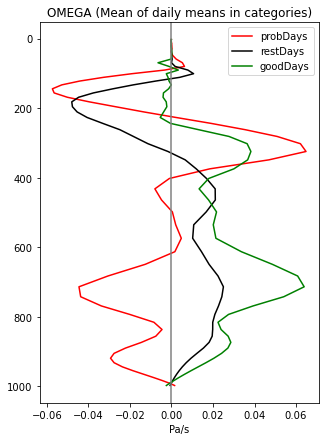

In [92]:
profVar = 'OMEGA'

fig,axs = plt.subplots(1,1, figsize=(5,7))
axs.plot(mean_probTimesStrict_IO_ctrlH1[profVar].values, mean_probTimesStrict_IO_ctrlH1.lev.values, 'r-',label='probDays')
axs.plot(mean_restTimesStrict_IO_ctrlH1[profVar].values, mean_restTimesStrict_IO_ctrlH1.lev.values, 'k-',label='restDays')
axs.plot(mean_goodTimesStrict_IO_ctrlH1[profVar].values, mean_goodTimesStrict_IO_ctrlH1.lev.values, 'g-',label='goodDays')
axs.set_title(profVar+' (Mean of daily means in categories)')
axs.legend()
axs.set_xlabel(IOpoint_ctrl[profVar].units)
axs.invert_yaxis()

axs.axvline(0,color='grey')


## Maybe look over a region, not just a point - better statistics? 

In [9]:
## Get regional DS
ilon_ATL = np.where((ctrlDS_h2.lon.values>=309) & (ctrlDS_h2.lon.values<=(309+33)))[0]
ilat_ATL = np.where((ctrlDS_h2.lat.values>=-2) & (ctrlDS_h2.lat.values<=(-2+20)))[0]
ATL_ctrlH2 = ctrlDS_h2.isel(lon=ilon_ATL, lat=ilat_ATL)
ATL_ctrlH1 = ctrlDS_h1.isel(lon=ilon_ATL, lat=ilat_ATL)
ATL32_ctrlH2 = ctrlDS32_h2.isel(lon=ilon_ATL, lat=ilat_ATL)
ATL_L32ds    = L32ds.isel(lon=ilon_ATL, lat=ilat_ATL)
ATL_L58ds    = L58ds.isel(lon=ilon_ATL, lat=ilat_ATL)

ilon_IO = np.where((ctrlDS_h2.lon.values>=60) & (ctrlDS_h2.lon.values<=(60+38)))[0]
ilat_IO = np.where((ctrlDS_h2.lat.values>=-3) & (ctrlDS_h2.lat.values<=(-3+8)))[0]
IO_ctrlH2 = ctrlDS_h2.isel(lon=ilon_IO, lat=ilat_IO)
IO_ctrlH1 = ctrlDS_h1.isel(lon=ilon_IO, lat=ilat_IO)
IO32_ctrlH2 = ctrlDS32_h2.isel(lon=ilon_IO, lat=ilat_IO)
IO_L32ds    = L32ds.isel(lon=ilon_IO, lat=ilat_IO)
IO_L58ds    = L58ds.isel(lon=ilon_IO, lat=ilat_IO)


ilon_WP = np.where((ctrlDS_h2.lon.values>=132) & (ctrlDS_h2.lon.values<=(132+40)))[0]
ilat_WP = np.where((ctrlDS_h2.lat.values>=-5) & (ctrlDS_h2.lat.values<=(-5+20)))[0]
WP_ctrlH2 = ctrlDS_h2.isel(lon=ilon_WP, lat=ilat_WP)
WP_ctrlH1 = ctrlDS_h1.isel(lon=ilon_WP, lat=ilat_WP)
WP32_ctrlH2 = ctrlDS32_h2.isel(lon=ilon_WP, lat=ilat_WP)
WP_L32ds    = L32ds.isel(lon=ilon_WP, lat=ilat_WP)
WP_L58ds    = L58ds.isel(lon=ilon_WP, lat=ilat_WP)



In [10]:
ATL_ocn32    = ocnMask32[ilat_ATL,:] 
ATL_ocn32    = ATL_ocn32[:,ilon_ATL]
ATL_ocn58    = ocnMask58[ilat_ATL,:] 
ATL_ocn58    = ATL_ocn58[:,ilon_ATL]

IO_ocn32    = ocnMask32[ilat_IO,:] 
IO_ocn32    = IO_ocn32[:,ilon_IO]
IO_ocn58    = ocnMask58[ilat_IO,:] 
IO_ocn58    = IO_ocn58[:,ilon_IO]

WP_ocn32    = ocnMask32[ilat_WP,:] 
WP_ocn32    = WP_ocn32[:,ilon_WP]
WP_ocn58    = ocnMask58[ilat_WP,:] 
WP_ocn58    = WP_ocn58[:,ilon_WP]


#### ATL

In [11]:
ATL_h2_probTimes_LHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_probTimes_SHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_probTimes_U10     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_probTimes_windBot = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_probTimes_n       = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
# These are values from the offline shr_flux_mod script:
ATL_probTimes_holCorr    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_probTimes_hol        = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_probTimes_stable     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_probTimes_rdOVrdn    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_probTimes_psimh      = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)

ATL_h2_goodTimes_LHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_goodTimes_SHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_goodTimes_U10     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_goodTimes_windBot = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_goodTimes_n       = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
# These are values from the offline shr_flux_mod script:
ATL_goodTimes_holCorr    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_goodTimes_hol        = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_goodTimes_stable     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_goodTimes_rdOVrdn    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_goodTimes_psimh      = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)

ATL_h2_restTimes_LHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_restTimes_SHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_restTimes_U10     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_restTimes_windBot = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_h2_restTimes_n       = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
# These are values from the offline shr_flux_mod script:
ATL_restTimes_holCorr    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_restTimes_hol        = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_restTimes_stable     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_restTimes_rdOVrdn    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL_restTimes_psimh      = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)

for ilat in range(len(ilat_ATL)):
    for ilon in range(len(ilon_ATL)): 
        ## Find times that fall in each category
        iTimesStrict = np.where( ATL_ctrlH2.isel(lat=ilat,lon=ilon).U10.values > (ATL_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values*1.1) )[0] 
        iTimesGood   = np.where( ATL_ctrlH2.isel(lat=ilat,lon=ilon).U10.values <= ATL_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values )[0] 

        restOfTimesStrict = np.arange(0, len(ATL_ctrlH2.isel(lat=ilat,lon=ilon).time.values))
        restOfTimesStrict = np.delete(restOfTimesStrict, iTimesStrict)

        ## Get mean values for each case... 
        if len(iTimesStrict)>0: 
            probTimesStrict_ATL_ctrlH2 = ATL_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')
            probTimesStrict_ATL_L58    = ATL_L58ds.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')
            
            ATL_h2_probTimes_LHFLX[ilat,ilon]   = probTimesStrict_ATL_ctrlH2.LHFLX.values
            ATL_h2_probTimes_SHFLX[ilat,ilon]   = probTimesStrict_ATL_ctrlH2.SHFLX.values
            ATL_h2_probTimes_U10[ilat,ilon]     = probTimesStrict_ATL_ctrlH2.U10.values
            ATL_h2_probTimes_windBot[ilat,ilon] = probTimesStrict_ATL_ctrlH2.windSpeedBot.values
            ATL_h2_probTimes_n[ilat,ilon]       = len(iTimesStrict)
            # Values from offline shr_flux_mod:
            ATL_probTimes_holCorr[ilat,ilon]    = probTimesStrict_ATL_L58.hol_corrected.values
            ATL_probTimes_hol[ilat,ilon]        = probTimesStrict_ATL_L58.hol.values
            ATL_probTimes_stable[ilat,ilon]     = probTimesStrict_ATL_L58.stable.values
            ATL_probTimes_rdOVrdn[ilat,ilon]    = probTimesStrict_ATL_L58.rd_ov_rdn.values
            ATL_probTimes_psimh[ilat,ilon]      = probTimesStrict_ATL_L58.psimh.values
            
            
        if len(restOfTimesStrict)>0:
            restTimesStrict_ATL_ctrlH2 = ATL_ctrlH2.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')
            restTimesStrict_ATL_L58    = ATL_L58ds.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')

            ATL_h2_restTimes_LHFLX[ilat,ilon]   = restTimesStrict_ATL_ctrlH2.LHFLX.values
            ATL_h2_restTimes_SHFLX[ilat,ilon]   = restTimesStrict_ATL_ctrlH2.SHFLX.values
            ATL_h2_restTimes_U10[ilat,ilon]     = restTimesStrict_ATL_ctrlH2.U10.values
            ATL_h2_restTimes_windBot[ilat,ilon] = restTimesStrict_ATL_ctrlH2.windSpeedBot.values
            ATL_h2_restTimes_n[ilat,ilon]       = len(restOfTimesStrict)
            # Values from offline shr_flux_mod:
            ATL_restTimes_holCorr[ilat,ilon]    = restTimesStrict_ATL_L58.hol_corrected.values
            ATL_restTimes_hol[ilat,ilon]        = restTimesStrict_ATL_L58.hol.values
            ATL_restTimes_stable[ilat,ilon]     = restTimesStrict_ATL_L58.stable.values
            ATL_restTimes_rdOVrdn[ilat,ilon]    = restTimesStrict_ATL_L58.rd_ov_rdn.values
            ATL_restTimes_psimh[ilat,ilon]      = restTimesStrict_ATL_L58.psimh.values

        if len(iTimesGood)>0:
            goodTimes_ATL_ctrlH2       = ATL_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')
            goodTimes_ATL_L58          = ATL_L58ds.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')

            ATL_h2_goodTimes_LHFLX[ilat,ilon]   = goodTimes_ATL_ctrlH2.LHFLX.values
            ATL_h2_goodTimes_SHFLX[ilat,ilon]   = goodTimes_ATL_ctrlH2.SHFLX.values
            ATL_h2_goodTimes_U10[ilat,ilon]     = goodTimes_ATL_ctrlH2.U10.values
            ATL_h2_goodTimes_windBot[ilat,ilon] = goodTimes_ATL_ctrlH2.windSpeedBot.values
            ATL_h2_goodTimes_n[ilat,ilon]       = len(iTimesGood)
            # Values from offline shr_flux_mod:
            ATL_goodTimes_holCorr[ilat,ilon]    = goodTimes_ATL_L58.hol_corrected.values
            ATL_goodTimes_hol[ilat,ilon]        = goodTimes_ATL_L58.hol.values
            ATL_goodTimes_stable[ilat,ilon]     = goodTimes_ATL_L58.stable.values
            ATL_goodTimes_rdOVrdn[ilat,ilon]    = goodTimes_ATL_L58.rd_ov_rdn.values
            ATL_goodTimes_psimh[ilat,ilon]      = goodTimes_ATL_L58.psimh.values
        



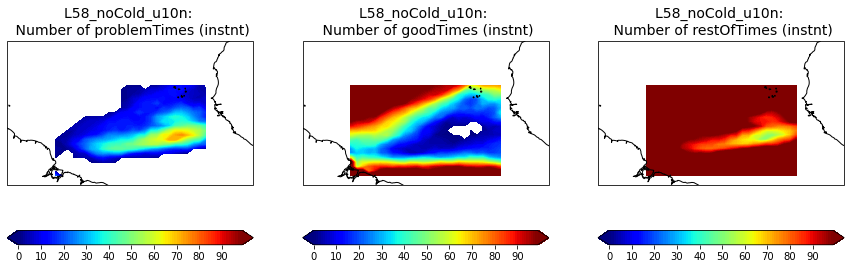

In [13]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,100)

## Problem times 
cplot = axs[0].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_probTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n Number of problemTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_goodTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n Number of goodTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_restTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n Number of restOfTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


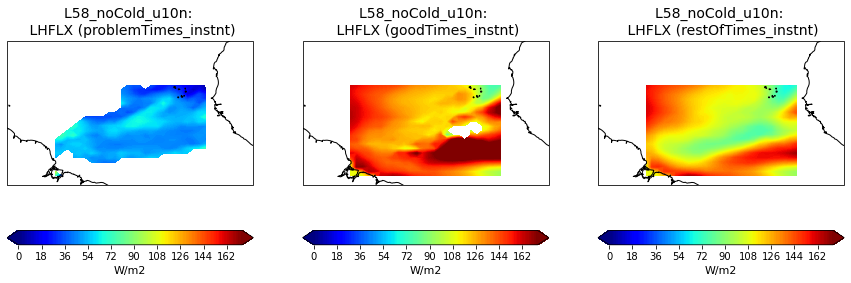

In [14]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,175)

## Problem times 
cplot = axs[0].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_probTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n LHFLX (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_goodTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n LHFLX (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_restTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n LHFLX (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


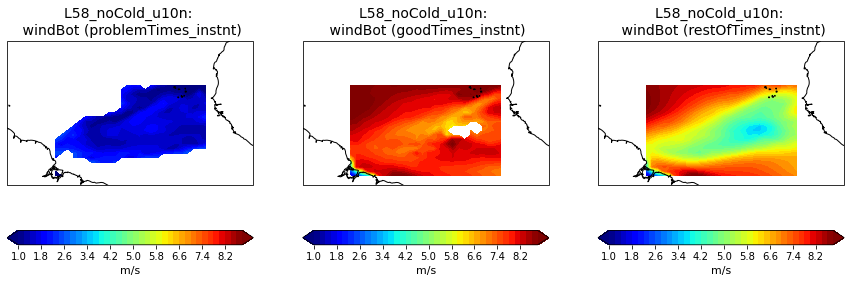

In [15]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(1,9,0.2)

## Problem times 
cplot = axs[0].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_probTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n windBot (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_goodTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n windBot (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_restTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n windBot (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


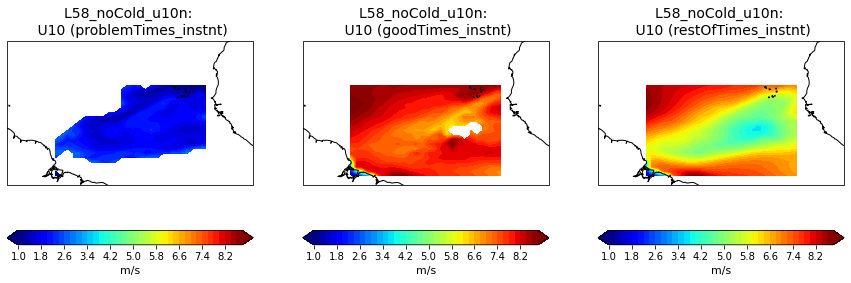

In [16]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(1,9,0.2)

## Problem times 
cplot = axs[0].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_probTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n U10 (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_goodTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n U10 (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_h2_restTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n U10 (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


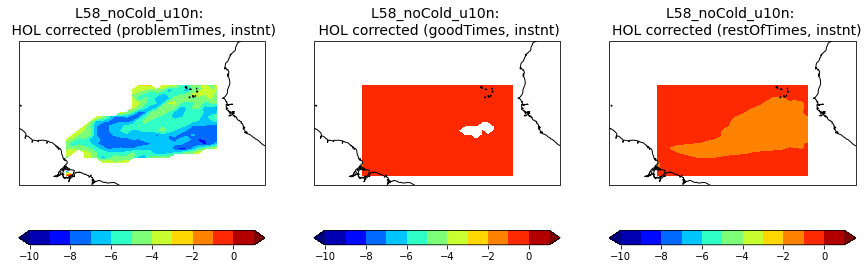

In [17]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(-10,2)

## Problem times 
cplot = axs[0].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_probTimes_holCorr, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n HOL corrected (problemTimes, instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_goodTimes_holCorr, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n HOL corrected (goodTimes, instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_restTimes_holCorr, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n  HOL corrected (restOfTimes, instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


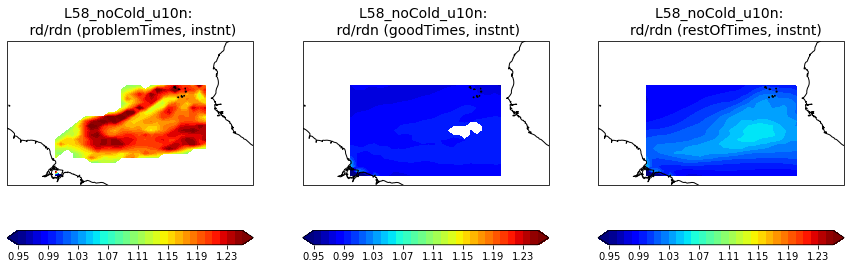

In [18]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0.95,1.25,0.01)

## Problem times 
cplot = axs[0].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_probTimes_rdOVrdn, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n rd/rdn (problemTimes, instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_goodTimes_rdOVrdn, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n rd/rdn (goodTimes, instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_restTimes_rdOVrdn, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n  rd/rdn (restOfTimes, instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


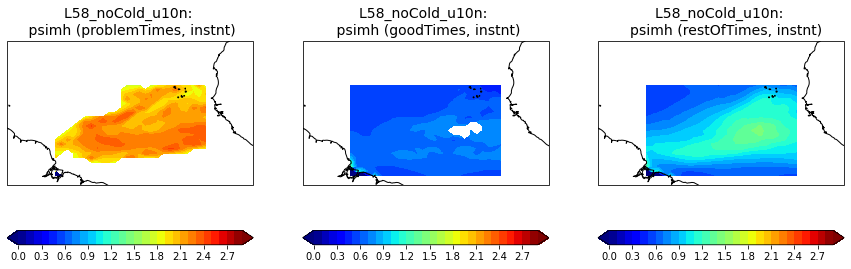

In [19]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,3,0.1)

## Problem times 
cplot = axs[0].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_probTimes_psimh, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n psimh (problemTimes, instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_goodTimes_psimh, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n psimh (goodTimes, instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL_ctrlH2.lon.values, ATL_ctrlH2.lat.values,
                        ATL_restTimes_psimh, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n  psimh (restOfTimes, instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


Text(0.5, 1.0, 'ProblemTimes (ATL)')

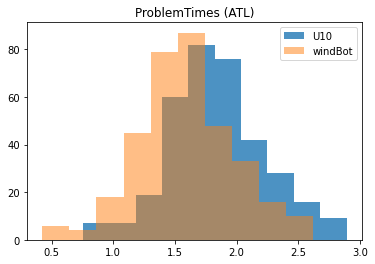

In [20]:
plt.hist(ATL_h2_probTimes_U10.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]),alpha=0.8, label='U10')
plt.hist(ATL_h2_probTimes_windBot.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]),alpha=0.5, label='windBot')
plt.legend()
plt.title('ProblemTimes (ATL)')



Text(0.5, 1.0, 'GoodTimes (ATL)')

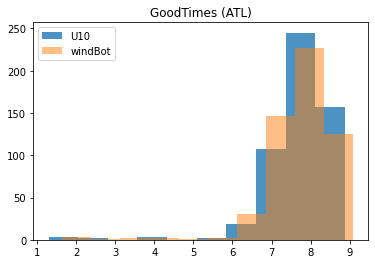

In [21]:
plt.hist(ATL_h2_goodTimes_U10.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]),alpha=0.8, label='U10')
plt.hist(ATL_h2_goodTimes_windBot.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]),alpha=0.5, label='windBot')
plt.legend()
plt.title('GoodTimes (ATL)')



Text(0.5, 1.0, 'psimh (ATL)')

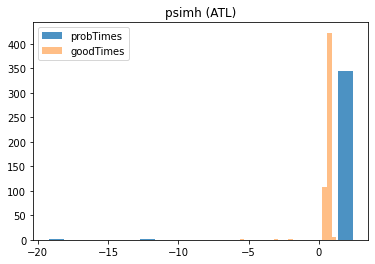

In [22]:
plt.hist(ATL_probTimes_psimh.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]), bins=20,alpha=0.8, label='probTimes')
plt.hist(ATL_goodTimes_psimh.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]), bins=20,alpha=0.5, label='goodTimes')
plt.legend()
plt.title('psimh (ATL)')

Text(0.5, 1.0, 'hol (corrected) (ATL)')

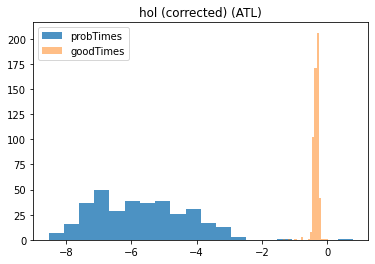

In [23]:
plt.hist(ATL_probTimes_holCorr.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]), bins=20,alpha=0.8, label='probTimes')
plt.hist(ATL_goodTimes_holCorr.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]), bins=20,alpha=0.5, label='goodTimes')
plt.legend()
plt.title('hol (corrected) (ATL)')



#### IO

In [12]:
IO_h2_probTimes_LHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_probTimes_SHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_probTimes_U10     = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_probTimes_windBot = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_probTimes_n       = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
# These are values from the offline shr_flux_mod script:
IO_probTimes_holCorr    = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_probTimes_hol        = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_probTimes_stable     = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_probTimes_rdOVrdn    = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_probTimes_psimh      = np.full([len(ilat_IO), len(ilon_IO)], np.nan)

IO_h2_goodTimes_LHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_goodTimes_SHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_goodTimes_U10     = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_goodTimes_windBot = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_goodTimes_n       = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
# These are values from the offline shr_flux_mod script:
IO_goodTimes_holCorr    = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_goodTimes_hol        = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_goodTimes_stable     = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_goodTimes_rdOVrdn    = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_goodTimes_psimh      = np.full([len(ilat_IO), len(ilon_IO)], np.nan)

IO_h2_restTimes_LHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_restTimes_SHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_restTimes_U10     = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_restTimes_windBot = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_h2_restTimes_n       = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
# These are values from the offline shr_flux_mod script:
IO_restTimes_holCorr    = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_restTimes_hol        = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_restTimes_stable     = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_restTimes_rdOVrdn    = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO_restTimes_psimh      = np.full([len(ilat_IO), len(ilon_IO)], np.nan)


for ilat in range(len(ilat_IO)):
    for ilon in range(len(ilon_IO)): 
        ## Find times that fall in each category
        iTimesStrict = np.where( IO_ctrlH2.isel(lat=ilat,lon=ilon).U10.values > (IO_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values*1.1) )[0] 
        iTimesGood   = np.where( IO_ctrlH2.isel(lat=ilat,lon=ilon).U10.values <= IO_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values )[0] 

        restOfTimesStrict = np.arange(0, len(IO_ctrlH2.isel(lat=ilat,lon=ilon).time.values))
        restOfTimesStrict = np.delete(restOfTimesStrict, iTimesStrict)

        ## Get mean values for each case... 
        if len(iTimesStrict)>0: 
            probTimesStrict_IO_ctrlH2 = IO_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')
            probTimesStrict_IO_L58    = IO_L58ds.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')

            
            IO_h2_probTimes_LHFLX[ilat,ilon]   = probTimesStrict_IO_ctrlH2.LHFLX.values
            IO_h2_probTimes_SHFLX[ilat,ilon]   = probTimesStrict_IO_ctrlH2.SHFLX.values
            IO_h2_probTimes_U10[ilat,ilon]     = probTimesStrict_IO_ctrlH2.U10.values
            IO_h2_probTimes_windBot[ilat,ilon] = probTimesStrict_IO_ctrlH2.windSpeedBot.values
            IO_h2_probTimes_n[ilat,ilon]       = len(iTimesStrict)
            # Values from offline shr_flux_mod:
            IO_probTimes_holCorr[ilat,ilon]    = probTimesStrict_IO_L58.hol_corrected.values
            IO_probTimes_hol[ilat,ilon]        = probTimesStrict_IO_L58.hol.values
            IO_probTimes_stable[ilat,ilon]     = probTimesStrict_IO_L58.stable.values
            IO_probTimes_rdOVrdn[ilat,ilon]    = probTimesStrict_IO_L58.rd_ov_rdn.values
            IO_probTimes_psimh[ilat,ilon]      = probTimesStrict_IO_L58.psimh.values
            
            
        if len(restOfTimesStrict)>0:
            restTimesStrict_IO_ctrlH2 = IO_ctrlH2.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')
            restTimesStrict_IO_L58    = IO_L58ds.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')

            IO_h2_restTimes_LHFLX[ilat,ilon]   = restTimesStrict_IO_ctrlH2.LHFLX.values
            IO_h2_restTimes_SHFLX[ilat,ilon]   = restTimesStrict_IO_ctrlH2.SHFLX.values
            IO_h2_restTimes_U10[ilat,ilon]     = restTimesStrict_IO_ctrlH2.U10.values
            IO_h2_restTimes_windBot[ilat,ilon] = restTimesStrict_IO_ctrlH2.windSpeedBot.values
            IO_h2_restTimes_n[ilat,ilon]       = len(restOfTimesStrict)
            # Values from offline shr_flux_mod:
            IO_restTimes_holCorr[ilat,ilon]    = restTimesStrict_IO_L58.hol_corrected.values
            IO_restTimes_hol[ilat,ilon]        = restTimesStrict_IO_L58.hol.values
            IO_restTimes_stable[ilat,ilon]     = restTimesStrict_IO_L58.stable.values
            IO_restTimes_rdOVrdn[ilat,ilon]    = restTimesStrict_IO_L58.rd_ov_rdn.values
            IO_restTimes_psimh[ilat,ilon]      = restTimesStrict_IO_L58.psimh.values

        if len(iTimesGood)>0:
            goodTimes_IO_ctrlH2       = IO_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')
            goodTimes_IO_L58          = IO_L58ds.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')

            
            IO_h2_goodTimes_LHFLX[ilat,ilon]   = goodTimes_IO_ctrlH2.LHFLX.values
            IO_h2_goodTimes_SHFLX[ilat,ilon]   = goodTimes_IO_ctrlH2.SHFLX.values
            IO_h2_goodTimes_U10[ilat,ilon]     = goodTimes_IO_ctrlH2.U10.values
            IO_h2_goodTimes_windBot[ilat,ilon] = goodTimes_IO_ctrlH2.windSpeedBot.values
            IO_h2_goodTimes_n[ilat,ilon]       = len(iTimesGood)
            # Values from offline shr_flux_mod:
            IO_goodTimes_holCorr[ilat,ilon]    = goodTimes_IO_L58.hol_corrected.values
            IO_goodTimes_hol[ilat,ilon]        = goodTimes_IO_L58.hol.values
            IO_goodTimes_stable[ilat,ilon]     = goodTimes_IO_L58.stable.values
            IO_goodTimes_rdOVrdn[ilat,ilon]    = goodTimes_IO_L58.rd_ov_rdn.values
            IO_goodTimes_psimh[ilat,ilon]      = goodTimes_IO_L58.psimh.values
    


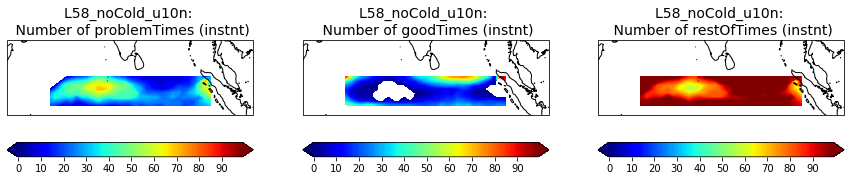

In [81]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,100)

## Problem times 
cplot = axs[0].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_probTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n Number of problemTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_goodTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n Number of goodTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_restTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n Number of restOfTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])


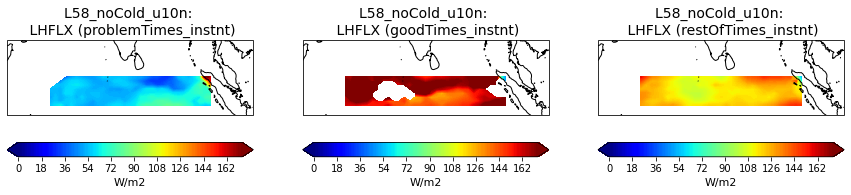

In [59]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,175)

## Problem times 
cplot = axs[0].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_probTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n LHFLX (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_goodTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n LHFLX (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_restTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n LHFLX (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])


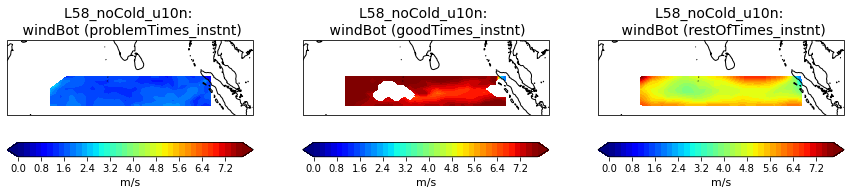

In [62]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,8,0.2)

## Problem times 
cplot = axs[0].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_probTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n windBot (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_goodTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n windBot (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_restTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n windBot (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])


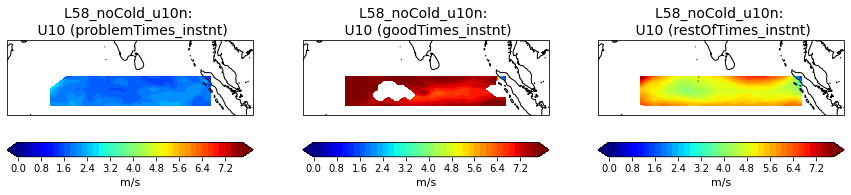

In [63]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,8,0.2)

## Problem times 
cplot = axs[0].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_probTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n U10 (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_goodTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n U10 (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_h2_restTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n U10 (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])


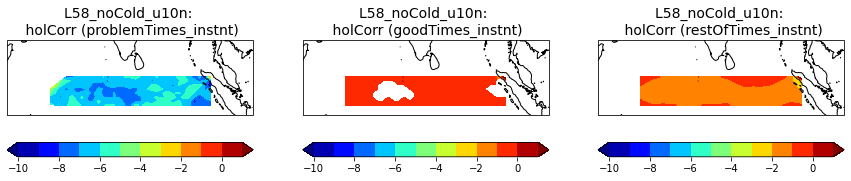

In [39]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(-10,2)

## Problem times 
cplot = axs[0].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_probTimes_holCorr, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n holCorr (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_goodTimes_holCorr, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n holCorr (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_restTimes_holCorr, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n holCorr (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])


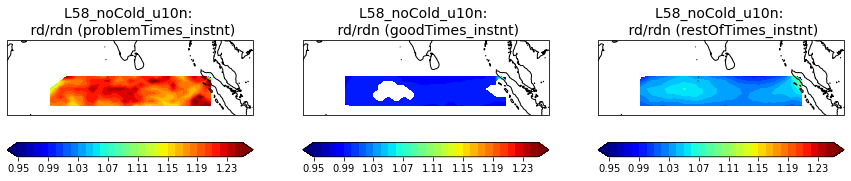

In [40]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0.95,1.25,0.01)

## Problem times 
cplot = axs[0].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_probTimes_rdOVrdn, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n rd/rdn (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_goodTimes_rdOVrdn, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n rd/rdn (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_restTimes_rdOVrdn, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n rd/rdn (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])


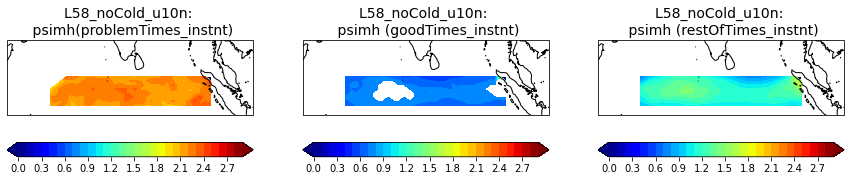

In [41]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,3,0.1)

## Problem times 
cplot = axs[0].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_probTimes_psimh, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n psimh(problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_goodTimes_psimh, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n psimh (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(IO_ctrlH2.lon.values, IO_ctrlH2.lat.values,
                        IO_restTimes_psimh, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n psimh (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])


[None, None, None, None]

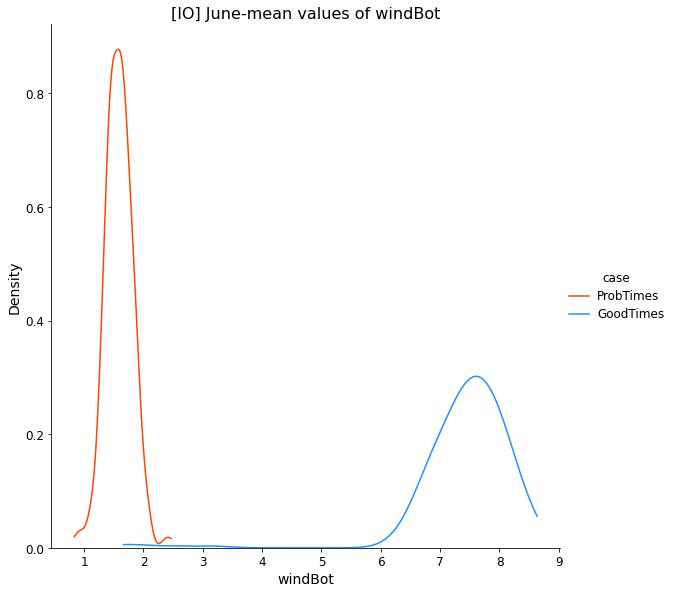

In [95]:
distVar = 'windBot'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: IO_h2_probTimes_windBot.reshape([len(IO_L32ds.lon.values)*len(IO_L32ds.lat.values)]), 'case': 'ProbTimes'}),
     pd.DataFrame.from_dict({distVar: IO_h2_goodTimes_windBot.reshape([len(IO_L58ds.lon.values)*len(IO_L58ds.lat.values)]), 'case': 'GoodTimes'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[IO] June-mean values of "+distVar, fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)



Text(0.5, 1.0, 'ProblemTimes (IO)')

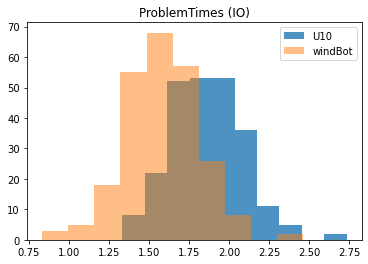

In [79]:
plt.hist(IO_h2_probTimes_U10.reshape([len(IO_ctrlH2.lon.values)*len(IO_ctrlH2.lat.values)]),alpha=0.8, label='U10')
plt.hist(IO_h2_probTimes_windBot.reshape([len(IO_ctrlH2.lon.values)*len(IO_ctrlH2.lat.values)]),alpha=0.5, label='windBot')
plt.legend()
plt.title('ProblemTimes (IO)')



Text(0.5, 1.0, 'GoodTimes (IO)')

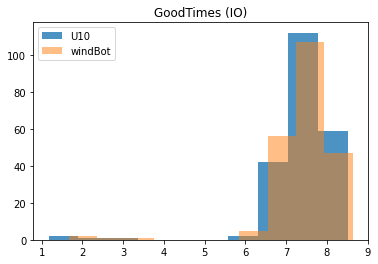

In [82]:
plt.hist(IO_h2_goodTimes_U10.reshape([len(IO_ctrlH2.lon.values)*len(IO_ctrlH2.lat.values)]),alpha=0.8, label='U10')
plt.hist(IO_h2_goodTimes_windBot.reshape([len(IO_ctrlH2.lon.values)*len(IO_ctrlH2.lat.values)]),alpha=0.5, label='windBot')
plt.legend()
plt.title('GoodTimes (IO)')



Text(0.5, 1.0, 'psimh (IO)')

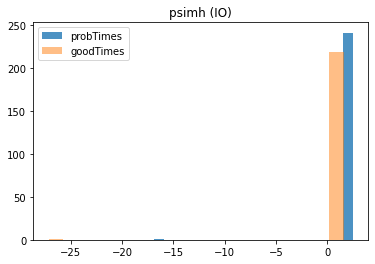

In [96]:
plt.hist(IO_probTimes_psimh.reshape([len(IO_ctrlH2.lon.values)*len(IO_ctrlH2.lat.values)]), bins=20,alpha=0.8, label='probTimes')
plt.hist(IO_goodTimes_psimh.reshape([len(IO_ctrlH2.lon.values)*len(IO_ctrlH2.lat.values)]), bins=20,alpha=0.5, label='goodTimes')
plt.legend()
plt.title('psimh (IO)')

Text(0.5, 1.0, 'HOL (corrected) (IO)')

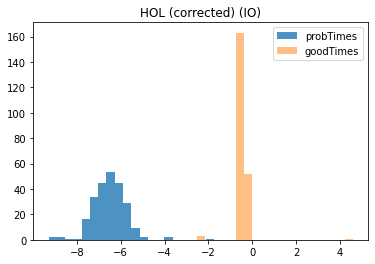

In [43]:
plt.hist(IO_probTimes_holCorr.reshape([len(IO_ctrlH2.lon.values)*len(IO_ctrlH2.lat.values)]), bins=20,alpha=0.8, label='probTimes')
plt.hist(IO_goodTimes_holCorr.reshape([len(IO_ctrlH2.lon.values)*len(IO_ctrlH2.lat.values)]), bins=20,alpha=0.5, label='goodTimes')
plt.legend()
plt.title('HOL (corrected) (IO)')

#### WP

In [13]:
WP_h2_probTimes_LHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_probTimes_SHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_probTimes_U10     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_probTimes_windBot = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_probTimes_n       = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
# These are values from the offline shr_flux_mod script:
WP_probTimes_holCorr    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_probTimes_hol        = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_probTimes_stable     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_probTimes_rdOVrdn    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_probTimes_psimh      = np.full([len(ilat_WP), len(ilon_WP)], np.nan)

WP_h2_goodTimes_LHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_goodTimes_SHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_goodTimes_U10     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_goodTimes_windBot = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_goodTimes_n       = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
# These are values from the offline shr_flux_mod script:
WP_goodTimes_holCorr    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_goodTimes_hol        = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_goodTimes_stable     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_goodTimes_rdOVrdn    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_goodTimes_psimh      = np.full([len(ilat_WP), len(ilon_WP)], np.nan)

WP_h2_restTimes_LHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_restTimes_SHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_restTimes_U10     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_restTimes_windBot = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_h2_restTimes_n       = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
# These are values from the offline shr_flux_mod script:
WP_restTimes_holCorr    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_restTimes_hol        = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_restTimes_stable     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_restTimes_rdOVrdn    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP_restTimes_psimh      = np.full([len(ilat_WP), len(ilon_WP)], np.nan)


for ilat in range(len(ilat_WP)):
    for ilon in range(len(ilon_WP)): 
        ## Find times that fall in each category
        iTimesStrict = np.where( WP_ctrlH2.isel(lat=ilat,lon=ilon).U10.values > (WP_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values*1.1) )[0] 
        iTimesGood   = np.where( WP_ctrlH2.isel(lat=ilat,lon=ilon).U10.values <= WP_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values )[0] 

        restOfTimesStrict = np.arange(0, len(WP_ctrlH2.isel(lat=ilat,lon=ilon).time.values))
        restOfTimesStrict = np.delete(restOfTimesStrict, iTimesStrict)

        ## Get mean values for each case... 
        if len(iTimesStrict)>0: 
            probTimesStrict_WP_ctrlH2 = WP_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')
            probTimesStrict_WP_L58    = WP_L58ds.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')

            
            WP_h2_probTimes_LHFLX[ilat,ilon]   = probTimesStrict_WP_ctrlH2.LHFLX.values
            WP_h2_probTimes_SHFLX[ilat,ilon]   = probTimesStrict_WP_ctrlH2.SHFLX.values
            WP_h2_probTimes_U10[ilat,ilon]     = probTimesStrict_WP_ctrlH2.U10.values
            WP_h2_probTimes_windBot[ilat,ilon] = probTimesStrict_WP_ctrlH2.windSpeedBot.values
            WP_h2_probTimes_n[ilat,ilon]       = len(iTimesStrict)
            # Values from offline shr_flux_mod:
            WP_probTimes_holCorr[ilat,ilon]    = probTimesStrict_WP_L58.hol_corrected.values
            WP_probTimes_hol[ilat,ilon]        = probTimesStrict_WP_L58.hol.values
            WP_probTimes_stable[ilat,ilon]     = probTimesStrict_WP_L58.stable.values
            WP_probTimes_rdOVrdn[ilat,ilon]    = probTimesStrict_WP_L58.rd_ov_rdn.values
            WP_probTimes_psimh[ilat,ilon]      = probTimesStrict_WP_L58.psimh.values
            
            
        if len(restOfTimesStrict)>0:
            restTimesStrict_WP_ctrlH2 = WP_ctrlH2.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')
            restTimesStrict_WP_L58    = WP_L58ds.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')

            WP_h2_restTimes_LHFLX[ilat,ilon]   = restTimesStrict_WP_ctrlH2.LHFLX.values
            WP_h2_restTimes_SHFLX[ilat,ilon]   = restTimesStrict_WP_ctrlH2.SHFLX.values
            WP_h2_restTimes_U10[ilat,ilon]     = restTimesStrict_WP_ctrlH2.U10.values
            WP_h2_restTimes_windBot[ilat,ilon] = restTimesStrict_WP_ctrlH2.windSpeedBot.values
            WP_h2_restTimes_n[ilat,ilon]       = len(restOfTimesStrict)
            # Values from offline shr_flux_mod:
            WP_restTimes_holCorr[ilat,ilon]    = restTimesStrict_WP_L58.hol_corrected.values
            WP_restTimes_hol[ilat,ilon]        = restTimesStrict_WP_L58.hol.values
            WP_restTimes_stable[ilat,ilon]     = restTimesStrict_WP_L58.stable.values
            WP_restTimes_rdOVrdn[ilat,ilon]    = restTimesStrict_WP_L58.rd_ov_rdn.values
            WP_restTimes_psimh[ilat,ilon]      = restTimesStrict_WP_L58.psimh.values

        if len(iTimesGood)>0:
            goodTimes_WP_ctrlH2       = WP_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')
            goodTimes_WP_L58          = WP_L58ds.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')

            
            WP_h2_goodTimes_LHFLX[ilat,ilon]   = goodTimes_WP_ctrlH2.LHFLX.values
            WP_h2_goodTimes_SHFLX[ilat,ilon]   = goodTimes_WP_ctrlH2.SHFLX.values
            WP_h2_goodTimes_U10[ilat,ilon]     = goodTimes_WP_ctrlH2.U10.values
            WP_h2_goodTimes_windBot[ilat,ilon] = goodTimes_WP_ctrlH2.windSpeedBot.values
            WP_h2_goodTimes_n[ilat,ilon]       = len(iTimesGood)
            # Values from offline shr_flux_mod:
            WP_goodTimes_holCorr[ilat,ilon]    = goodTimes_WP_L58.hol_corrected.values
            WP_goodTimes_hol[ilat,ilon]        = goodTimes_WP_L58.hol.values
            WP_goodTimes_stable[ilat,ilon]     = goodTimes_WP_L58.stable.values
            WP_goodTimes_rdOVrdn[ilat,ilon]    = goodTimes_WP_L58.rd_ov_rdn.values
            WP_goodTimes_psimh[ilat,ilon]      = goodTimes_WP_L58.psimh.values
    


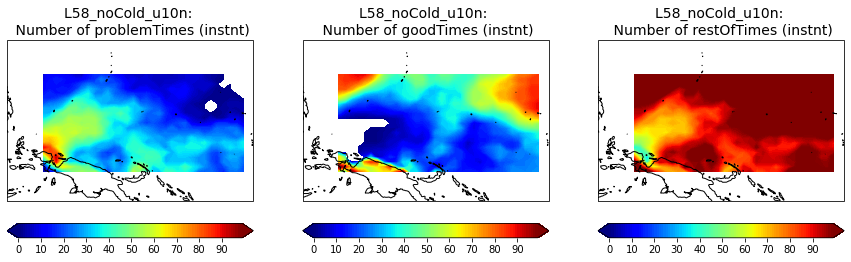

In [98]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,100)

## Problem times 
cplot = axs[0].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_probTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n Number of problemTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_goodTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n Number of goodTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_restTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n Number of restOfTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[1].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[2].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])


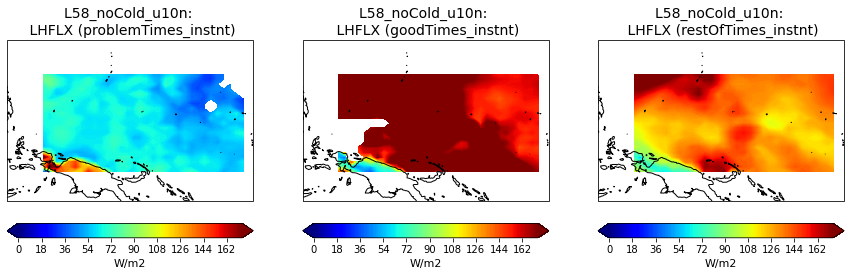

In [73]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,175)

## Problem times 
cplot = axs[0].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_probTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n LHFLX (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_goodTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n LHFLX (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_restTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n LHFLX (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[1].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[2].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])



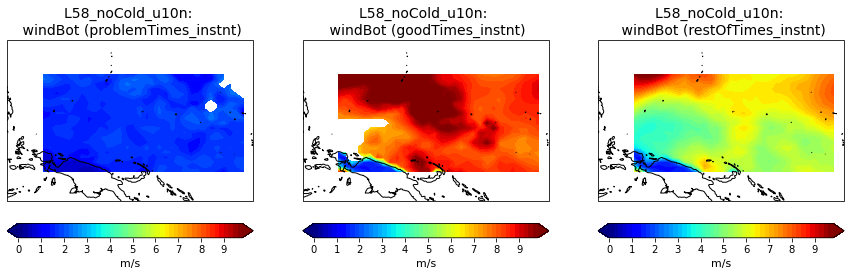

In [75]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,10,0.2)

## Problem times 
cplot = axs[0].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_probTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n windBot (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_goodTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n windBot (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_restTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n windBot (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[1].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[2].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])


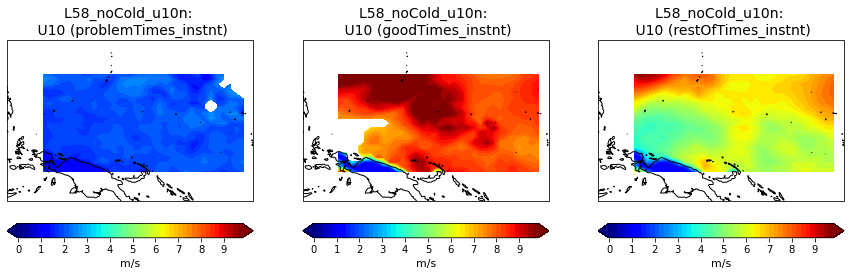

In [76]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,10,0.2)

## Problem times 
cplot = axs[0].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_probTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58_noCold_u10n: \n U10 (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_goodTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58_noCold_u10n: \n U10 (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(WP_ctrlH2.lon.values, WP_ctrlH2.lat.values,
                        WP_h2_restTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L58_noCold_u10n: \n U10 (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[1].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[2].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])


[None, None, None, None]

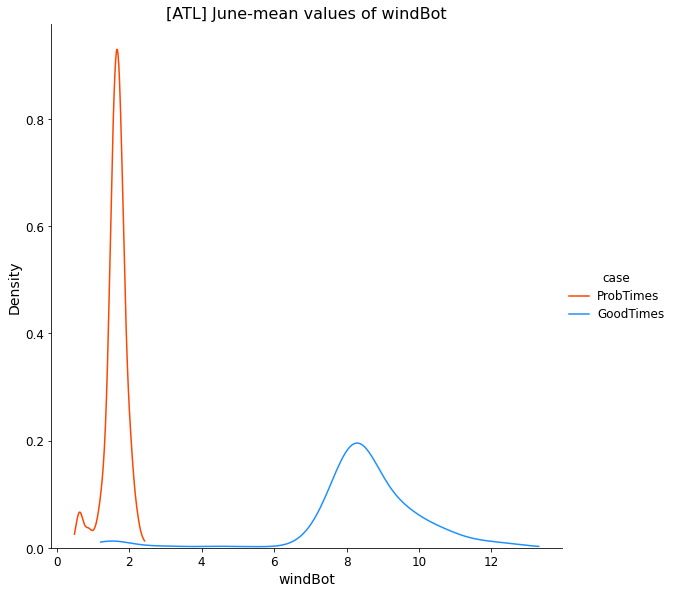

In [99]:
distVar = 'windBot'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: WP_h2_probTimes_windBot.reshape([len(WP_L32ds.lon.values)*len(WP_L32ds.lat.values)]), 'case': 'ProbTimes'}),
     pd.DataFrame.from_dict({distVar: WP_h2_goodTimes_windBot.reshape([len(WP_L58ds.lon.values)*len(WP_L58ds.lat.values)]), 'case': 'GoodTimes'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[ATL] June-mean values of "+distVar, fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)



### L32, as above

In [14]:
ATL32_h2_probTimes_LHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_probTimes_SHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_probTimes_U10     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_probTimes_windBot = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_probTimes_n       = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
# These are values from the offline shr_flux_mod script:
ATL32_probTimes_holCorr    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_probTimes_hol        = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_probTimes_stable     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_probTimes_rdOVrdn    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_probTimes_psimh      = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)

ATL32_h2_goodTimes_LHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_goodTimes_SHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_goodTimes_U10     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_goodTimes_windBot = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_goodTimes_n       = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
# These are values from the offline shr_flux_mod script:
ATL32_goodTimes_holCorr    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_goodTimes_hol        = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_goodTimes_stable     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_goodTimes_rdOVrdn    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_goodTimes_psimh      = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)

ATL32_h2_restTimes_LHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_restTimes_SHFLX   = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_restTimes_U10     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_restTimes_windBot = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_h2_restTimes_n       = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
# These are values from the offline shr_flux_mod script:
ATL32_restTimes_holCorr    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_restTimes_hol        = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_restTimes_stable     = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_restTimes_rdOVrdn    = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)
ATL32_restTimes_psimh      = np.full([len(ilat_ATL), len(ilon_ATL)], np.nan)


for ilat in range(len(ilat_ATL)):
    for ilon in range(len(ilon_ATL)): 
        ## Find times that fall in each category
        iTimesStrict = np.where( ATL32_ctrlH2.isel(lat=ilat,lon=ilon).U10.values > (ATL32_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values*1.1) )[0] 
        iTimesGood   = np.where( ATL32_ctrlH2.isel(lat=ilat,lon=ilon).U10.values <= ATL32_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values )[0] 

        restOfTimesStrict = np.arange(0, len(ATL32_ctrlH2.isel(lat=ilat,lon=ilon).time.values))
        restOfTimesStrict = np.delete(restOfTimesStrict, iTimesStrict)

        ## Get mean values for each case... 
        if len(iTimesStrict)>0: 
            probTimesStrict_ATL_ctrlH2 = ATL32_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')
            probTimesStrict_ATL_L32    = ATL_L32ds.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')

            ATL32_h2_probTimes_LHFLX[ilat,ilon]   = probTimesStrict_ATL_ctrlH2.LHFLX.values
            ATL32_h2_probTimes_SHFLX[ilat,ilon]   = probTimesStrict_ATL_ctrlH2.SHFLX.values
            ATL32_h2_probTimes_U10[ilat,ilon]     = probTimesStrict_ATL_ctrlH2.U10.values
            ATL32_h2_probTimes_windBot[ilat,ilon] = probTimesStrict_ATL_ctrlH2.windSpeedBot.values
            ATL32_h2_probTimes_n[ilat,ilon]       = len(iTimesStrict)
            # Values from offline shr_flux_mod:
            ATL32_probTimes_holCorr[ilat,ilon]    = probTimesStrict_ATL_L32.hol_corrected.values
            ATL32_probTimes_hol[ilat,ilon]        = probTimesStrict_ATL_L32.hol.values
            ATL32_probTimes_stable[ilat,ilon]     = probTimesStrict_ATL_L32.stable.values
            ATL32_probTimes_rdOVrdn[ilat,ilon]    = probTimesStrict_ATL_L32.rd_ov_rdn.values
            ATL32_probTimes_psimh[ilat,ilon]      = probTimesStrict_ATL_L32.psimh.values
            
            
            
        if len(restOfTimesStrict)>0:
            restTimesStrict_ATL_ctrlH2 = ATL32_ctrlH2.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')
            restTimesStrict_ATL_L32    = ATL_L32ds.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')
           
            ATL32_h2_restTimes_LHFLX[ilat,ilon]   = restTimesStrict_ATL_ctrlH2.LHFLX.values
            ATL32_h2_restTimes_SHFLX[ilat,ilon]   = restTimesStrict_ATL_ctrlH2.SHFLX.values
            ATL32_h2_restTimes_U10[ilat,ilon]     = restTimesStrict_ATL_ctrlH2.U10.values
            ATL32_h2_restTimes_windBot[ilat,ilon] = restTimesStrict_ATL_ctrlH2.windSpeedBot.values
            ATL32_h2_restTimes_n[ilat,ilon]       = len(restOfTimesStrict)
            # Values from offline shr_flux_mod:
            ATL32_restTimes_holCorr[ilat,ilon]    = restTimesStrict_ATL_L32.hol_corrected.values
            ATL32_restTimes_hol[ilat,ilon]        = restTimesStrict_ATL_L32.hol.values
            ATL32_restTimes_stable[ilat,ilon]     = restTimesStrict_ATL_L32.stable.values
            ATL32_restTimes_rdOVrdn[ilat,ilon]    = restTimesStrict_ATL_L32.rd_ov_rdn.values
            ATL32_restTimes_psimh[ilat,ilon]      = restTimesStrict_ATL_L32.psimh.values

        if len(iTimesGood)>0:
            goodTimes_ATL_ctrlH2       = ATL32_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')
            goodTimes_ATL_L32          = ATL_L32ds.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')

            ATL32_h2_goodTimes_LHFLX[ilat,ilon]   = goodTimes_ATL_ctrlH2.LHFLX.values
            ATL32_h2_goodTimes_SHFLX[ilat,ilon]   = goodTimes_ATL_ctrlH2.SHFLX.values
            ATL32_h2_goodTimes_U10[ilat,ilon]     = goodTimes_ATL_ctrlH2.U10.values
            ATL32_h2_goodTimes_windBot[ilat,ilon] = goodTimes_ATL_ctrlH2.windSpeedBot.values
            ATL32_h2_goodTimes_n[ilat,ilon]       = len(iTimesGood)
            # Values from offline shr_flux_mod:
            ATL32_goodTimes_holCorr[ilat,ilon]    = goodTimes_ATL_L32.hol_corrected.values
            ATL32_goodTimes_hol[ilat,ilon]        = goodTimes_ATL_L32.hol.values
            ATL32_goodTimes_stable[ilat,ilon]     = goodTimes_ATL_L32.stable.values
            ATL32_goodTimes_rdOVrdn[ilat,ilon]    = goodTimes_ATL_L32.rd_ov_rdn.values
            ATL32_goodTimes_psimh[ilat,ilon]      = goodTimes_ATL_L32.psimh.values
        



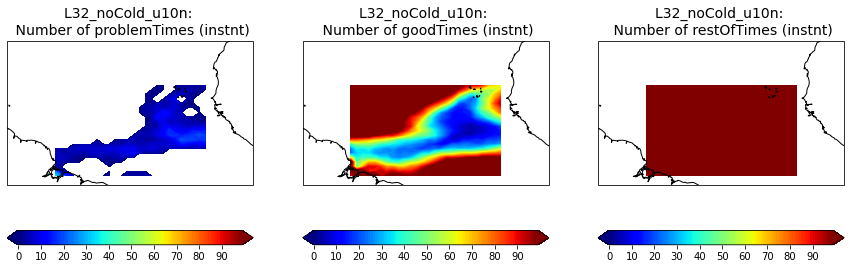

In [111]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,100)

## Problem times 
cplot = axs[0].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_probTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32_noCold_u10n: \n Number of problemTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_goodTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32_noCold_u10n: \n Number of goodTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_restTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32_noCold_u10n: \n Number of restOfTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(ATL32_ctrlH2.lon.values)-10,
                   np.max(ATL32_ctrlH2.lon.values)+10,
                   np.min(ATL32_ctrlH2.lat.values)-2,
                   np.max(ATL32_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL32_ctrlH2.lon.values)-10,
                   np.max(ATL32_ctrlH2.lon.values)+10,
                   np.min(ATL32_ctrlH2.lat.values)-2,
                   np.max(ATL32_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL32_ctrlH2.lon.values)-10,
                   np.max(ATL32_ctrlH2.lon.values)+10,
                   np.min(ATL32_ctrlH2.lat.values)-2,
                   np.max(ATL32_ctrlH2.lat.values)+7])


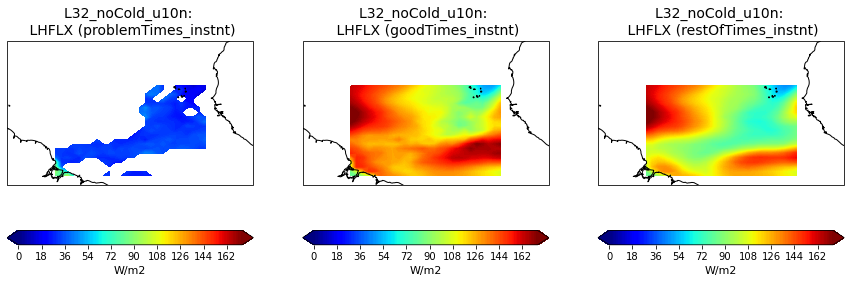

In [112]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,175)

## Problem times 
cplot = axs[0].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_probTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32_noCold_u10n: \n LHFLX (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_goodTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32_noCold_u10n: \n LHFLX (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_restTimes_LHFLX, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32_noCold_u10n: \n LHFLX (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


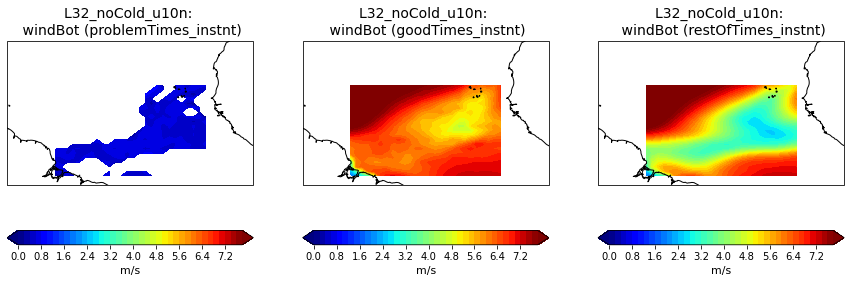

In [119]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,8,0.2)

## Problem times 
cplot = axs[0].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_probTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32_noCold_u10n: \n windBot (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_goodTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32_noCold_u10n: \n windBot (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_restTimes_windBot, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32_noCold_u10n: \n windBot (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


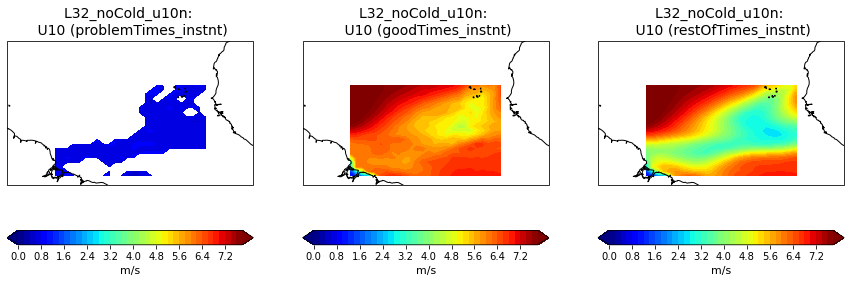

In [120]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,8,0.2)

## Problem times 
cplot = axs[0].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_probTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32_noCold_u10n: \n U10 (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_goodTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32_noCold_u10n: \n U10 (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_h2_restTimes_U10, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32_noCold_u10n: \n U10 (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(ctrlDS_h2['U10'].units,fontsize=11)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


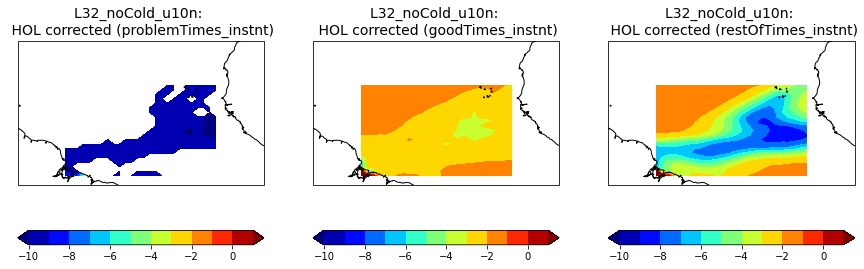

In [47]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(-10,2)

## Problem times 
cplot = axs[0].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_probTimes_holCorr, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32_noCold_u10n: \n HOL corrected (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

## Good times
cplot = axs[1].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_goodTimes_holCorr, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32_noCold_u10n: \n HOL corrected (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

## Rest of times
cplot = axs[2].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_restTimes_holCorr, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32_noCold_u10n: \n HOL corrected (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


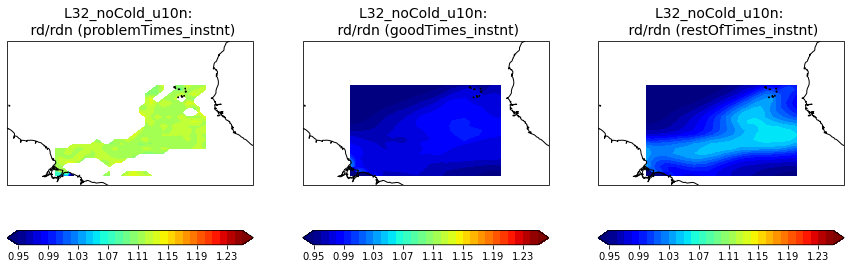

In [48]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0.95,1.25,0.01)

## Problem times 
cplot = axs[0].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_probTimes_rdOVrdn, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32_noCold_u10n: \n rd/rdn (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

## Good times
cplot = axs[1].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_goodTimes_rdOVrdn, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32_noCold_u10n: \n rd/rdn (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

## Rest of times
cplot = axs[2].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_restTimes_rdOVrdn, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32_noCold_u10n: \n rd/rdn (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


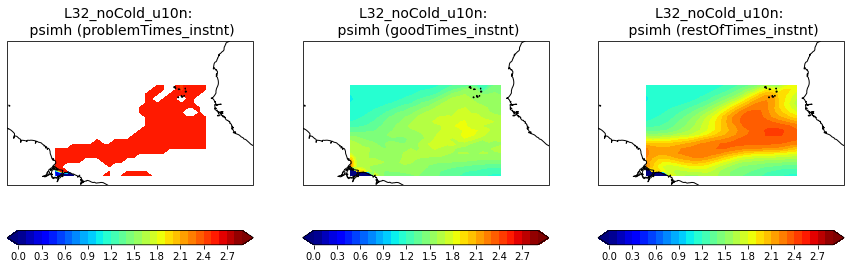

In [52]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,3,0.1)

## Problem times 
cplot = axs[0].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_probTimes_psimh, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32_noCold_u10n: \n psimh (problemTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

## Good times
cplot = axs[1].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_goodTimes_psimh, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32_noCold_u10n: \n psimh (goodTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

## Rest of times
cplot = axs[2].contourf(ATL32_ctrlH2.lon.values, ATL32_ctrlH2.lat.values,
                        ATL32_restTimes_psimh, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32_noCold_u10n: \n psimh (restOfTimes_instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[0].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(ATL_ctrlH2.lon.values)-10,
                   np.max(ATL_ctrlH2.lon.values)+10,
                   np.min(ATL_ctrlH2.lat.values)-2,
                   np.max(ATL_ctrlH2.lat.values)+7])


Text(0.5, 1.0, 'ProblemTimes L32 (ATL)')

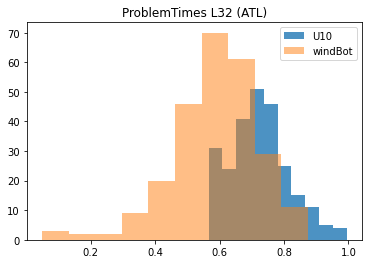

In [116]:
plt.hist(ATL32_h2_probTimes_U10.reshape([len(ATL32_ctrlH2.lon.values)*len(ATL32_ctrlH2.lat.values)]),alpha=0.8, label='U10')
plt.hist(ATL32_h2_probTimes_windBot.reshape([len(ATL32_ctrlH2.lon.values)*len(ATL32_ctrlH2.lat.values)]),alpha=0.5, label='windBot')
plt.legend()
plt.title('ProblemTimes L32 (ATL)')



Text(0.5, 1.0, 'GoodTimes L32 (ATL)')

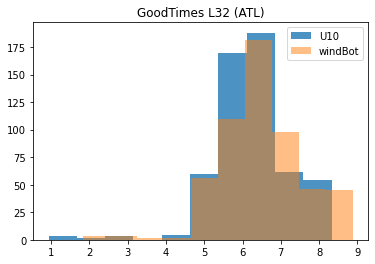

In [117]:
plt.hist(ATL32_h2_goodTimes_U10.reshape([len(ATL32_ctrlH2.lon.values)*len(ATL32_ctrlH2.lat.values)]),alpha=0.8, label='U10')
plt.hist(ATL32_h2_goodTimes_windBot.reshape([len(ATL32_ctrlH2.lon.values)*len(ATL32_ctrlH2.lat.values)]),alpha=0.5, label='windBot')
plt.legend()
plt.title('GoodTimes L32 (ATL)')



In [15]:
IO32_h2_probTimes_LHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_probTimes_SHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_probTimes_U10     = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_probTimes_windBot = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_probTimes_n       = np.full([len(ilat_IO), len(ilon_IO)], np.nan)

IO32_h2_goodTimes_LHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_goodTimes_SHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_goodTimes_U10     = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_goodTimes_windBot = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_goodTimes_n       = np.full([len(ilat_IO), len(ilon_IO)], np.nan)

IO32_h2_restTimes_LHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_restTimes_SHFLX   = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_restTimes_U10     = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_restTimes_windBot = np.full([len(ilat_IO), len(ilon_IO)], np.nan)
IO32_h2_restTimes_n       = np.full([len(ilat_IO), len(ilon_IO)], np.nan)


for ilat in range(len(ilat_IO)):
    for ilon in range(len(ilon_IO)): 
        ## Find times that fall in each category
        iTimesStrict = np.where( IO32_ctrlH2.isel(lat=ilat,lon=ilon).U10.values > (IO32_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values*1.1) )[0] 
        iTimesGood   = np.where( IO32_ctrlH2.isel(lat=ilat,lon=ilon).U10.values <= IO32_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values )[0] 

        restOfTimesStrict = np.arange(0, len(IO32_ctrlH2.isel(lat=ilat,lon=ilon).time.values))
        restOfTimesStrict = np.delete(restOfTimesStrict, iTimesStrict)

        ## Get mean values for each case... 
        if len(iTimesStrict)>0: 
            probTimesStrict_IO_ctrlH2 = IO32_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')
            
            IO32_h2_probTimes_LHFLX[ilat,ilon]   = probTimesStrict_IO_ctrlH2.LHFLX.values
            IO32_h2_probTimes_SHFLX[ilat,ilon]   = probTimesStrict_IO_ctrlH2.SHFLX.values
            IO32_h2_probTimes_U10[ilat,ilon]     = probTimesStrict_IO_ctrlH2.U10.values
            IO32_h2_probTimes_windBot[ilat,ilon] = probTimesStrict_IO_ctrlH2.windSpeedBot.values
            IO32_h2_probTimes_n[ilat,ilon]       = len(iTimesStrict)
            
            
        if len(restOfTimesStrict)>0:
            restTimesStrict_IO_ctrlH2 = IO32_ctrlH2.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')
            
            IO32_h2_restTimes_LHFLX[ilat,ilon]   = restTimesStrict_IO_ctrlH2.LHFLX.values
            IO32_h2_restTimes_SHFLX[ilat,ilon]   = restTimesStrict_IO_ctrlH2.SHFLX.values
            IO32_h2_restTimes_U10[ilat,ilon]     = restTimesStrict_IO_ctrlH2.U10.values
            IO32_h2_restTimes_windBot[ilat,ilon] = restTimesStrict_IO_ctrlH2.windSpeedBot.values
            IO32_h2_restTimes_n[ilat,ilon]       = len(restOfTimesStrict)

        if len(iTimesGood)>0:
            goodTimes_IO_ctrlH2       = IO32_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')
            
            IO32_h2_goodTimes_LHFLX[ilat,ilon]   = goodTimes_IO_ctrlH2.LHFLX.values
            IO32_h2_goodTimes_SHFLX[ilat,ilon]   = goodTimes_IO_ctrlH2.SHFLX.values
            IO32_h2_goodTimes_U10[ilat,ilon]     = goodTimes_IO_ctrlH2.U10.values
            IO32_h2_goodTimes_windBot[ilat,ilon] = goodTimes_IO_ctrlH2.windSpeedBot.values
            IO32_h2_goodTimes_n[ilat,ilon]       = len(iTimesGood)
        



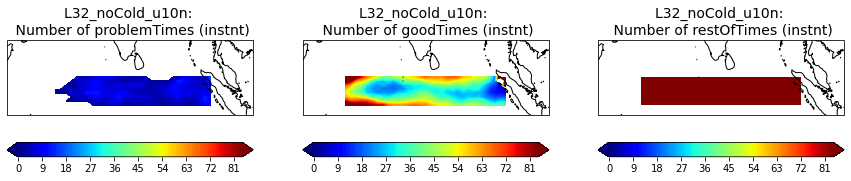

In [124]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,85)

## Problem times 
cplot = axs[0].contourf(IO32_ctrlH2.lon.values, IO32_ctrlH2.lat.values,
                        IO32_h2_probTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32_noCold_u10n: \n Number of problemTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(IO32_ctrlH2.lon.values, IO32_ctrlH2.lat.values,
                        IO32_h2_goodTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32_noCold_u10n: \n Number of goodTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(IO32_ctrlH2.lon.values, IO32_ctrlH2.lat.values,
                        IO32_h2_restTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32_noCold_u10n: \n Number of restOfTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[1].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])

axs[2].set_extent([np.min(IO_ctrlH2.lon.values)-10,
                   np.max(IO_ctrlH2.lon.values)+10,
                   np.min(IO_ctrlH2.lat.values)-2,
                   np.max(IO_ctrlH2.lat.values)+7])


Text(0.5, 1.0, 'ProblemTimes L32 (ATL)')

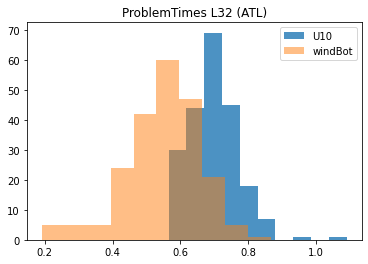

In [125]:
plt.hist(IO32_h2_probTimes_U10.reshape([len(IO32_ctrlH2.lon.values)*len(IO32_ctrlH2.lat.values)]),alpha=0.8, label='U10')
plt.hist(IO32_h2_probTimes_windBot.reshape([len(IO32_ctrlH2.lon.values)*len(IO32_ctrlH2.lat.values)]),alpha=0.5, label='windBot')
plt.legend()
plt.title('ProblemTimes L32 (ATL)')


Text(0.5, 1.0, 'GoodTimes L32 (ATL)')

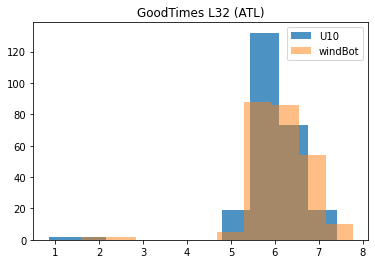

In [126]:
plt.hist(IO32_h2_goodTimes_U10.reshape([len(IO32_ctrlH2.lon.values)*len(IO32_ctrlH2.lat.values)]),alpha=0.8, label='U10')
plt.hist(IO32_h2_goodTimes_windBot.reshape([len(IO32_ctrlH2.lon.values)*len(IO32_ctrlH2.lat.values)]),alpha=0.5, label='windBot')
plt.legend()
plt.title('GoodTimes L32 (ATL)')


Text(0.5, 1.0, 'psimh (ATL) L32')

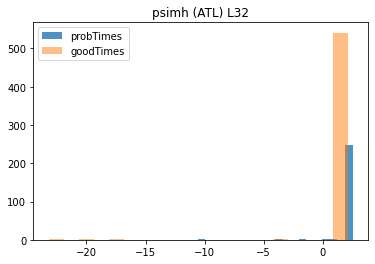

In [53]:
plt.hist(ATL32_probTimes_psimh.reshape([len(ATL32_ctrlH2.lon.values)*len(ATL32_ctrlH2.lat.values)]), bins=20,alpha=0.8, label='probTimes')
plt.hist(ATL32_goodTimes_psimh.reshape([len(ATL32_ctrlH2.lon.values)*len(ATL32_ctrlH2.lat.values)]), bins=20,alpha=0.5, label='goodTimes')
plt.legend()
plt.title('psimh (ATL) L32')

Text(0.5, 1.0, 'HOL (corrected) (ATL) L32')

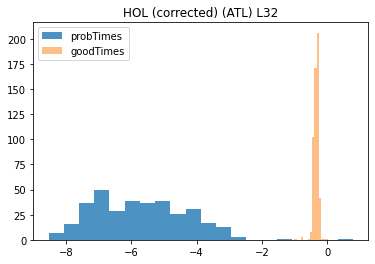

In [54]:
plt.hist(ATL_probTimes_holCorr.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]), bins=20,alpha=0.8, label='probTimes')
plt.hist(ATL_goodTimes_holCorr.reshape([len(ATL_ctrlH2.lon.values)*len(ATL_ctrlH2.lat.values)]), bins=20,alpha=0.5, label='goodTimes')
plt.legend()
plt.title('HOL (corrected) (ATL) L32')

In [16]:
WP32_h2_probTimes_LHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_probTimes_SHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_probTimes_U10     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_probTimes_windBot = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_probTimes_n       = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
# These are values from the offline shr_flux_mod script:
WP32_probTimes_holCorr    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_probTimes_hol        = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_probTimes_stable     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_probTimes_rdOVrdn    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_probTimes_psimh      = np.full([len(ilat_WP), len(ilon_WP)], np.nan)

WP32_h2_goodTimes_LHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_goodTimes_SHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_goodTimes_U10     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_goodTimes_windBot = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_goodTimes_n       = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
# These are values from the offline shr_flux_mod script:
WP32_goodTimes_holCorr    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_goodTimes_hol        = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_goodTimes_stable     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_goodTimes_rdOVrdn    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_goodTimes_psimh      = np.full([len(ilat_WP), len(ilon_WP)], np.nan)

WP32_h2_restTimes_LHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_restTimes_SHFLX   = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_restTimes_U10     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_restTimes_windBot = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_h2_restTimes_n       = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
# These are values from the offline shr_flux_mod script:
WP32_restTimes_holCorr    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_restTimes_hol        = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_restTimes_stable     = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_restTimes_rdOVrdn    = np.full([len(ilat_WP), len(ilon_WP)], np.nan)
WP32_restTimes_psimh      = np.full([len(ilat_WP), len(ilon_WP)], np.nan)


for ilat in range(len(ilat_WP)):
    for ilon in range(len(ilon_WP)): 
        ## Find times that fall in each category
        iTimesStrict = np.where( WP32_ctrlH2.isel(lat=ilat,lon=ilon).U10.values > (WP32_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values*1.1) )[0] 
        iTimesGood   = np.where( WP32_ctrlH2.isel(lat=ilat,lon=ilon).U10.values <= WP32_ctrlH2.isel(lat=ilat,lon=ilon).windSpeedBot.values )[0] 

        restOfTimesStrict = np.arange(0, len(WP32_ctrlH2.isel(lat=ilat,lon=ilon).time.values))
        restOfTimesStrict = np.delete(restOfTimesStrict, iTimesStrict)

        ## Get mean values for each case... 
        if len(iTimesStrict)>0: 
            probTimesStrict_WP_ctrlH2 = WP32_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')
            probTimesStrict_WP_L32    = WP_L32ds.isel(lat=ilat,lon=ilon,time=iTimesStrict).mean(dim='time')
                
            WP32_h2_probTimes_LHFLX[ilat,ilon]   = probTimesStrict_WP_ctrlH2.LHFLX.values
            WP32_h2_probTimes_SHFLX[ilat,ilon]   = probTimesStrict_WP_ctrlH2.SHFLX.values
            WP32_h2_probTimes_U10[ilat,ilon]     = probTimesStrict_WP_ctrlH2.U10.values
            WP32_h2_probTimes_windBot[ilat,ilon] = probTimesStrict_WP_ctrlH2.windSpeedBot.values
            WP32_h2_probTimes_n[ilat,ilon]       = len(iTimesStrict)
            # Values from offline shr_flux_mod:
            WP32_probTimes_holCorr[ilat,ilon]    = probTimesStrict_WP_L32.hol_corrected.values
            WP32_probTimes_hol[ilat,ilon]        = probTimesStrict_WP_L32.hol.values
            WP32_probTimes_stable[ilat,ilon]     = probTimesStrict_WP_L32.stable.values
            WP32_probTimes_rdOVrdn[ilat,ilon]    = probTimesStrict_WP_L32.rd_ov_rdn.values
            WP32_probTimes_psimh[ilat,ilon]      = probTimesStrict_WP_L32.psimh.values            
            
        if len(restOfTimesStrict)>0:
            restTimesStrict_WP_ctrlH2 = WP32_ctrlH2.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')
            restTimesStrict_WP_L32    = WP_L32ds.isel(lat=ilat,lon=ilon,time=restOfTimesStrict).mean(dim='time')

            WP32_h2_restTimes_LHFLX[ilat,ilon]   = restTimesStrict_WP_ctrlH2.LHFLX.values
            WP32_h2_restTimes_SHFLX[ilat,ilon]   = restTimesStrict_WP_ctrlH2.SHFLX.values
            WP32_h2_restTimes_U10[ilat,ilon]     = restTimesStrict_WP_ctrlH2.U10.values
            WP32_h2_restTimes_windBot[ilat,ilon] = restTimesStrict_WP_ctrlH2.windSpeedBot.values
            WP32_h2_restTimes_n[ilat,ilon]       = len(restOfTimesStrict)
            # Values from offline shr_flux_mod:
            WP32_restTimes_holCorr[ilat,ilon]    = restTimesStrict_WP_L32.hol_corrected.values
            WP32_restTimes_hol[ilat,ilon]        = restTimesStrict_WP_L32.hol.values
            WP32_restTimes_stable[ilat,ilon]     = restTimesStrict_WP_L32.stable.values
            WP32_restTimes_rdOVrdn[ilat,ilon]    = restTimesStrict_WP_L32.rd_ov_rdn.values
            WP32_restTimes_psimh[ilat,ilon]      = restTimesStrict_WP_L32.psimh.values   

        if len(iTimesGood)>0:
            goodTimes_WP_ctrlH2       = WP32_ctrlH2.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')
            goodTimes_WP_L32          = WP_L32ds.isel(lat=ilat,lon=ilon,time=iTimesGood).mean(dim='time')

            WP32_h2_goodTimes_LHFLX[ilat,ilon]   = goodTimes_WP_ctrlH2.LHFLX.values
            WP32_h2_goodTimes_SHFLX[ilat,ilon]   = goodTimes_WP_ctrlH2.SHFLX.values
            WP32_h2_goodTimes_U10[ilat,ilon]     = goodTimes_WP_ctrlH2.U10.values
            WP32_h2_goodTimes_windBot[ilat,ilon] = goodTimes_WP_ctrlH2.windSpeedBot.values
            WP32_h2_goodTimes_n[ilat,ilon]       = len(iTimesGood)
            # Values from offline shr_flux_mod:
            WP32_goodTimes_holCorr[ilat,ilon]    = goodTimes_WP_L32.hol_corrected.values
            WP32_goodTimes_hol[ilat,ilon]        = goodTimes_WP_L32.hol.values
            WP32_goodTimes_stable[ilat,ilon]     = goodTimes_WP_L32.stable.values
            WP32_goodTimes_rdOVrdn[ilat,ilon]    = goodTimes_WP_L32.rd_ov_rdn.values
            WP32_goodTimes_psimh[ilat,ilon]      = goodTimes_WP_L32.psimh.values 
        



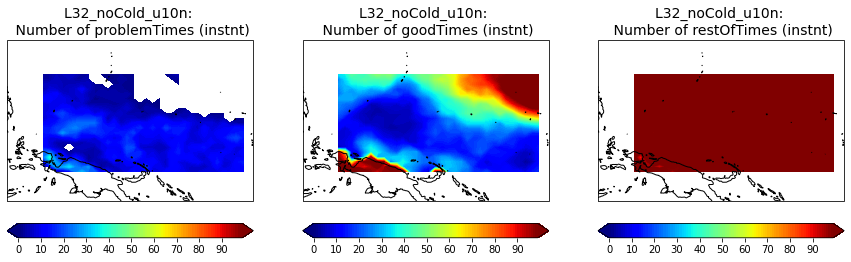

In [112]:
fig,axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

levsMap = np.arange(0,100)

## Problem times 
cplot = axs[0].contourf(WP32_ctrlH2.lon.values, WP32_ctrlH2.lat.values,
                        WP32_h2_probTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L32_noCold_u10n: \n Number of problemTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Good times
cplot = axs[1].contourf(WP32_ctrlH2.lon.values, WP32_ctrlH2.lat.values,
                        WP32_h2_goodTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L32_noCold_u10n: \n Number of goodTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

## Rest of times
cplot = axs[2].contourf(WP32_ctrlH2.lon.values, WP32_ctrlH2.lat.values,
                        WP32_h2_restTimes_n, 
                        levsMap, cmap='jet', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[2].coastlines()
axs[2].set_title('L32_noCold_u10n: \n Number of restOfTimes (instnt)',fontsize=14)
## Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(ctrlDS_h2['LHFLX'].units,fontsize=11)

axs[0].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[1].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])

axs[2].set_extent([np.min(WP_ctrlH2.lon.values)-7,
                   np.max(WP_ctrlH2.lon.values)+2,
                   np.min(WP_ctrlH2.lat.values)-5,
                   np.max(WP_ctrlH2.lat.values)+5])


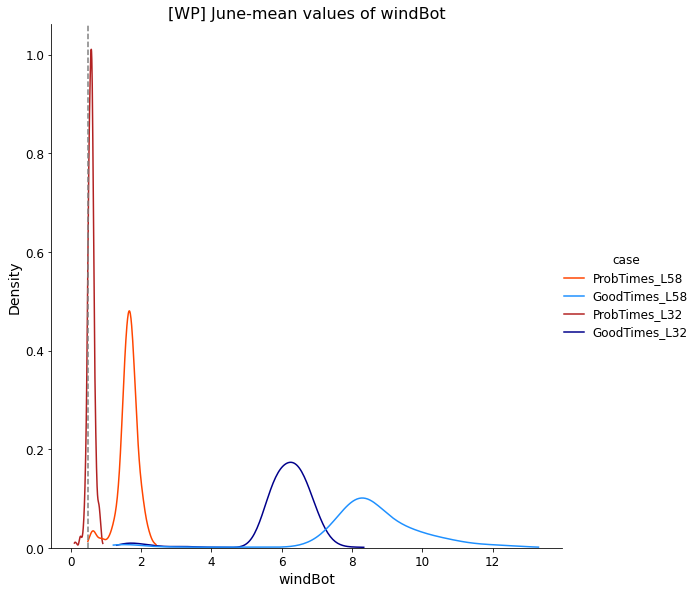

In [18]:
distVar = 'windBot'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: WP_h2_probTimes_windBot.reshape([len(WP_L32ds.lon.values)*len(WP_L32ds.lat.values)]), 'case': 'ProbTimes_L58'}),
     pd.DataFrame.from_dict({distVar: WP_h2_goodTimes_windBot.reshape([len(WP_L58ds.lon.values)*len(WP_L58ds.lat.values)]), 'case': 'GoodTimes_L58'}),
     pd.DataFrame.from_dict({distVar: WP32_h2_probTimes_windBot.reshape([len(WP_L32ds.lon.values)*len(WP_L32ds.lat.values)]), 'case': 'ProbTimes_L32'}),
     pd.DataFrame.from_dict({distVar: WP32_h2_goodTimes_windBot.reshape([len(WP_L58ds.lon.values)*len(WP_L58ds.lat.values)]), 'case': 'GoodTimes_L32'}),
 ])

# Make plot 
# g = sns.displot(dfReal, x=distVar, hue='case', kind='hist', height=8, 
#                 palette=['orangered','dodgerblue','firebrick','mediumblue'])

g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8,cut=0, 
                palette=['orangered','dodgerblue','firebrick','darkblue'])

g.ax.set_title("[WP] June-mean values of "+distVar, fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)
g.ax.axvline(0.5,color='grey',linestyle='--')


[None, None, None, None, None, None, None, None]

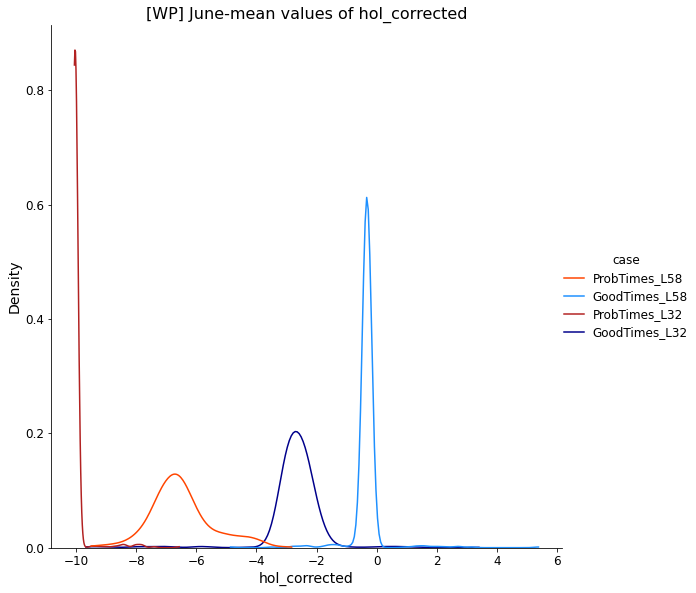

In [24]:
distVar = 'hol_corrected'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: WP_probTimes_holCorr.reshape([len(WP_L32ds.lon.values)*len(WP_L32ds.lat.values)]), 'case': 'ProbTimes_L58'}),
     pd.DataFrame.from_dict({distVar: WP_goodTimes_holCorr.reshape([len(WP_L58ds.lon.values)*len(WP_L58ds.lat.values)]), 'case': 'GoodTimes_L58'}),
     pd.DataFrame.from_dict({distVar: WP32_probTimes_holCorr.reshape([len(WP_L32ds.lon.values)*len(WP_L32ds.lat.values)]), 'case': 'ProbTimes_L32'}),
     pd.DataFrame.from_dict({distVar: WP32_goodTimes_holCorr.reshape([len(WP_L58ds.lon.values)*len(WP_L58ds.lat.values)]), 'case': 'GoodTimes_L32'}),
 ])

# Make plot 
# g = sns.displot(dfReal, x=distVar, hue='case', kind='hist', height=8, 
#                 palette=['orangered','dodgerblue','firebrick','mediumblue'])

g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8,cut=0, 
                palette=['orangered','dodgerblue','firebrick','darkblue'])

g.ax.set_title("[WP] June-mean values of "+distVar, fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)
# g.ax.axvline(0.5,color='grey',linestyle='--')


(-15.0, 5.0)

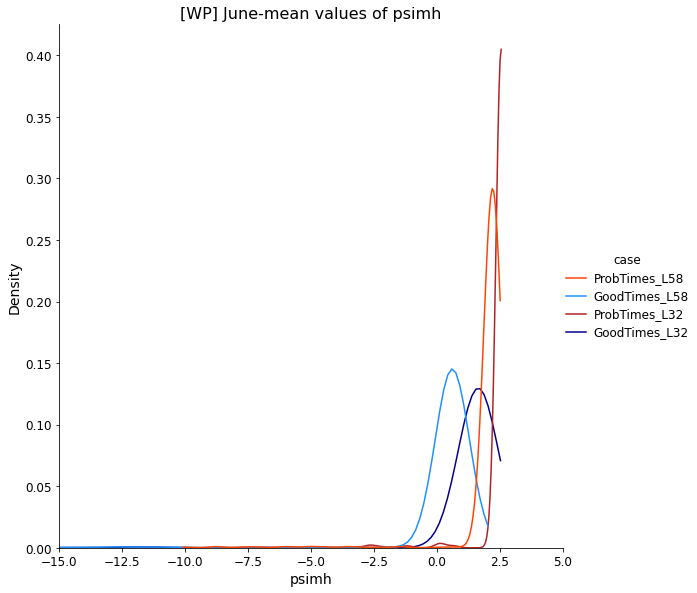

In [26]:
distVar = 'psimh'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: WP_probTimes_psimh.reshape([len(WP_L32ds.lon.values)*len(WP_L32ds.lat.values)]), 'case': 'ProbTimes_L58'}),
     pd.DataFrame.from_dict({distVar: WP_goodTimes_psimh.reshape([len(WP_L58ds.lon.values)*len(WP_L58ds.lat.values)]), 'case': 'GoodTimes_L58'}),
     pd.DataFrame.from_dict({distVar: WP32_probTimes_psimh.reshape([len(WP_L32ds.lon.values)*len(WP_L32ds.lat.values)]), 'case': 'ProbTimes_L32'}),
     pd.DataFrame.from_dict({distVar: WP32_goodTimes_psimh.reshape([len(WP_L58ds.lon.values)*len(WP_L58ds.lat.values)]), 'case': 'GoodTimes_L32'}),
 ])

# Make plot 
# g = sns.displot(dfReal, x=distVar, hue='case', kind='hist', height=8, 
#                 palette=['orangered','dodgerblue','firebrick','mediumblue'])

g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8,cut=0, 
                palette=['orangered','dodgerblue','firebrick','darkblue'])

g.ax.set_title("[WP] June-mean values of "+distVar, fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)
# g.ax.axvline(0.5,color='grey',linestyle='--')
g.ax.set_xlim([-15,5])


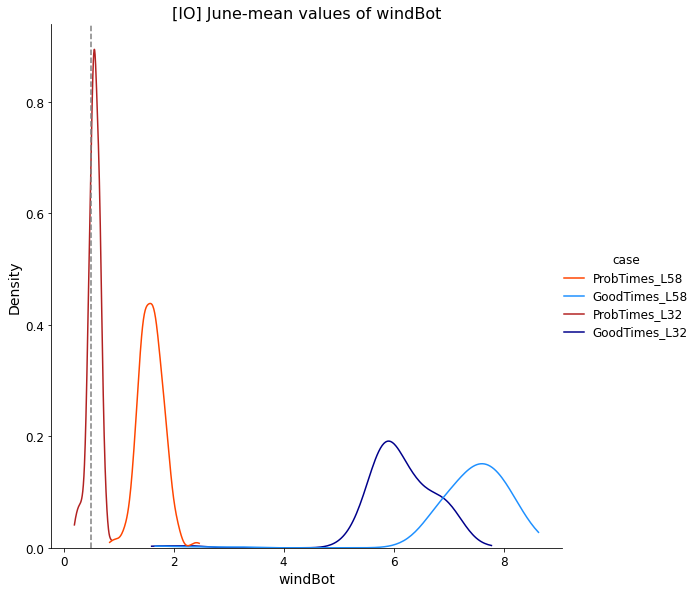

In [27]:
distVar = 'windBot'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: IO_h2_probTimes_windBot.reshape([len(IO_L32ds.lon.values)*len(IO_L32ds.lat.values)]), 'case': 'ProbTimes_L58'}),
     pd.DataFrame.from_dict({distVar: IO_h2_goodTimes_windBot.reshape([len(IO_L58ds.lon.values)*len(IO_L58ds.lat.values)]), 'case': 'GoodTimes_L58'}),
     pd.DataFrame.from_dict({distVar: IO32_h2_probTimes_windBot.reshape([len(IO_L32ds.lon.values)*len(IO_L32ds.lat.values)]), 'case': 'ProbTimes_L32'}),
     pd.DataFrame.from_dict({distVar: IO32_h2_goodTimes_windBot.reshape([len(IO_L58ds.lon.values)*len(IO_L58ds.lat.values)]), 'case': 'GoodTimes_L32'}),
 ])

# Make plot 
# g = sns.displot(dfReal, x=distVar, hue='case', kind='hist', height=8, 
#                 palette=['orangered','dodgerblue','firebrick','mediumblue'])

g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8,cut=0, 
                palette=['orangered','dodgerblue','firebrick','darkblue'])

g.ax.set_title("[IO] June-mean values of "+distVar, fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)
g.ax.axvline(0.5,color='grey',linestyle='--')


## Contrast values in L32 and L58?

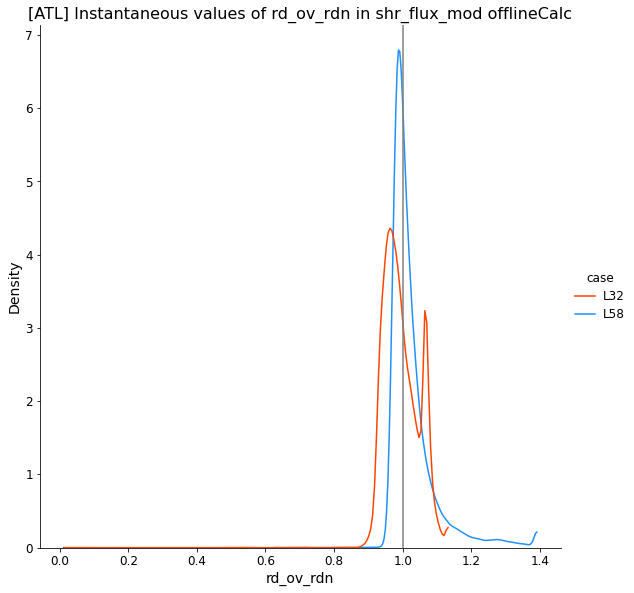

In [33]:
distVar = 'rd_ov_rdn'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(ATL_L32ds[distVar].values*ATL_ocn32).reshape([len(ATL_L32ds.lon.values)*len(ATL_L32ds.lat.values)*len(ATL_L32ds.time.values)]), 'case': 'L32'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(ATL_L58ds[distVar].values*ATL_ocn58).reshape([len(ATL_L58ds.lon.values)*len(ATL_L58ds.lat.values)*len(ATL_L58ds.time.values)]), 'case': 'L58'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[ATL] Instantaneous values of "+distVar+" in shr_flux_mod offlineCalc", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)

g.ax.axvline(1, color='grey')



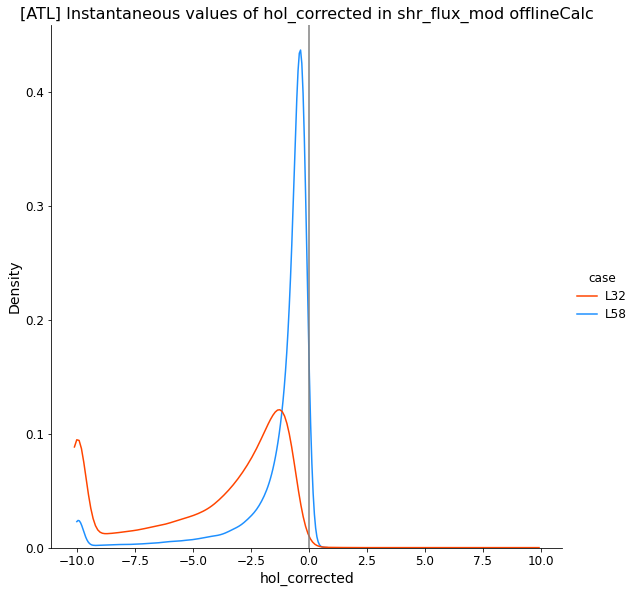

In [34]:
distVar = 'hol_corrected'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(ATL_L32ds[distVar].values*ATL_ocn32).reshape([len(ATL_L32ds.lon.values)*len(ATL_L32ds.lat.values)*len(L32ds.time.values)]), 'case': 'L32'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(ATL_L58ds[distVar].values*ATL_ocn58).reshape([len(ATL_L58ds.lon.values)*len(ATL_L58ds.lat.values)*len(L32ds.time.values)]), 'case': 'L58'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[ATL] Instantaneous values of "+distVar+" in shr_flux_mod offlineCalc", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)

g.ax.axvline(0, color='grey')



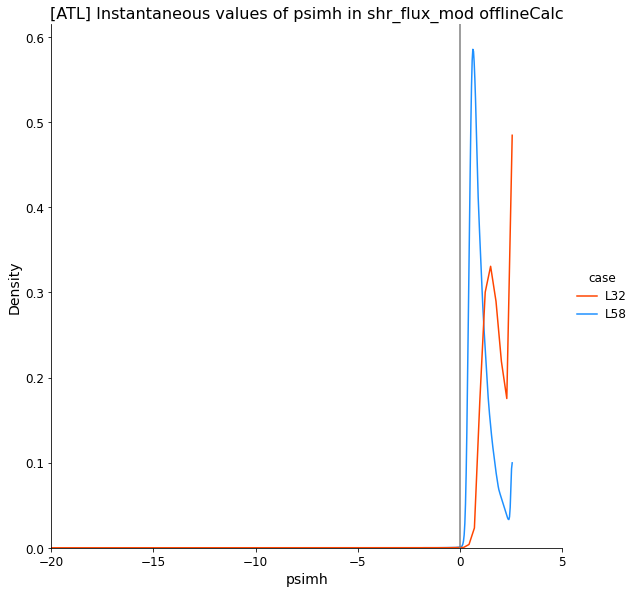

In [41]:
distVar = 'psimh'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(ATL_L32ds[distVar].values*ATL_ocn32).reshape([len(ATL_L32ds.lon.values)*len(ATL_L32ds.lat.values)*len(L32ds.time.values)]), 'case': 'L32'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(ATL_L58ds[distVar].values*ATL_ocn58).reshape([len(ATL_L58ds.lon.values)*len(ATL_L58ds.lat.values)*len(L32ds.time.values)]), 'case': 'L58'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[ATL] Instantaneous values of "+distVar+" in shr_flux_mod offlineCalc", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.set_xlim([-20,5])
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)

g.ax.axvline(0, color='grey')



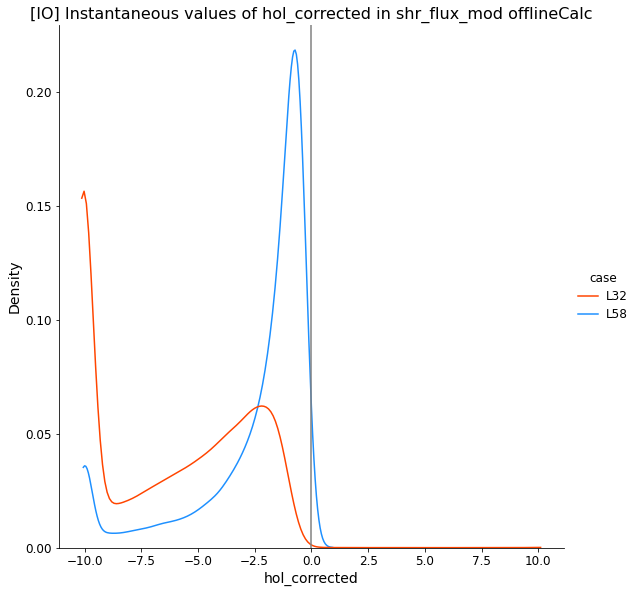

In [35]:
distVar = 'hol_corrected'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(IO_L32ds[distVar].values*IO_ocn32).reshape([len(IO_L32ds.lon.values)*len(IO_L32ds.lat.values)*len(L32ds.time.values)]), 'case': 'L32'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(IO_L58ds[distVar].values*IO_ocn58).reshape([len(IO_L58ds.lon.values)*len(IO_L58ds.lat.values)*len(L32ds.time.values)]), 'case': 'L58'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[IO] Instantaneous values of "+distVar+" in shr_flux_mod offlineCalc", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)

g.ax.axvline(0, color='grey')



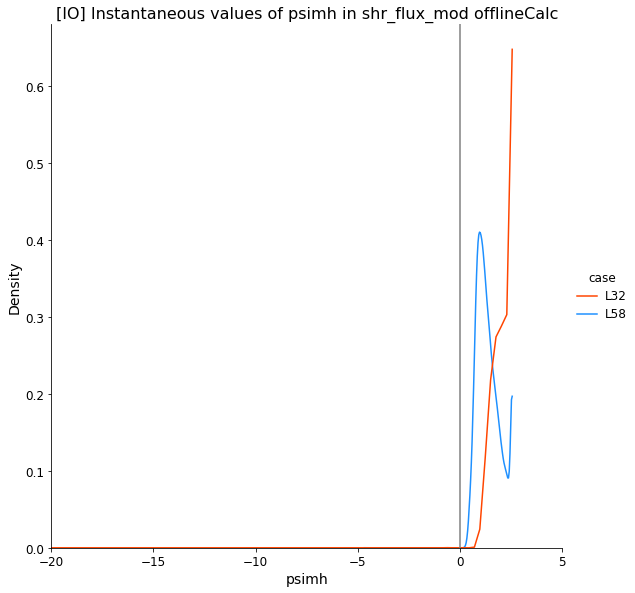

In [40]:
distVar = 'psimh'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(IO_L32ds[distVar].values*IO_ocn32).reshape([len(IO_L32ds.lon.values)*len(IO_L32ds.lat.values)*len(L32ds.time.values)]), 'case': 'L32'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(IO_L58ds[distVar].values*IO_ocn58).reshape([len(IO_L58ds.lon.values)*len(IO_L58ds.lat.values)*len(L32ds.time.values)]), 'case': 'L58'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("[IO] Instantaneous values of "+distVar+" in shr_flux_mod offlineCalc", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
g.ax.set_xlim([-20,5])
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)

g.ax.axvline(0, color='grey')



## Sanity checks: 
* Does UBOT == lowest level U? 
* Are we biasing ourselves by using the first year of JJA?

**Quick sanity check:** Does UBOT = U.isel(lev=-1)??

In [50]:
testDir  = '/glade/scratch/mdfowler/archive/F2010climo.f09_f09_mg17.TestGustGlobal_Control_58Lcam6_branch.003/atm/hist/'
testFile = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58Lcam6_branch.003.cam.h1.0004-01-01-10800.nc'

testDS = xr.open_dataset(testDir+testFile, decode_times=True)


In [53]:
Udiffs = testDS.UBOT.values - testDS.isel(lev=-1).U.values

In [54]:
print( np.nanmax(Udiffs), np.nanmin(Udiffs) )

0.0 0.0


So the answer is *yes*, UBOT is identical to the lowest level U. That's not the source of the issue. 

**Another question:** Does it make sense to use just year 1? Is that going to be super different than using a longer period or only the second year, or...?

In [55]:
def combineFields(saveDir, caseStart, maxYr): 
    fileEnds_h1 = ['_1dVars.nc','_lowLevelUV.nc','_lowLevelT.nc']
    fileEnds_h0 = ['_tau.nc']


    for iEnd in range(len(fileEnds_h1)):

        ## Daily data 
        listFiles = np.sort(glob.glob(saveDir+caseStart+'*h1*'+fileEnds_h1[iEnd]))
        if len(listFiles)>1:
            print('WARNING: more than one matching file found; using first file in list') 
            print(listFiles)

        ds = xr.open_dataset(listFiles[0], decode_times=True)

        iYrs = np.where(ds['time.year'] <= maxYr)[0]
        ds   = ds.isel(time=iYrs) 

        if iEnd==0:
            caseDS_h1 = ds 
        else: 
            caseDS_h1 = xr.merge([caseDS_h1, ds]) 

    for iEnd in range(len(fileEnds_h0)):
        ## Monthly data 
        listFiles = np.sort(glob.glob(saveDir+caseStart+'*h0*'+fileEnds_h0[iEnd]))
        if len(listFiles)>1:
            print('WARNING: more than one matching file found; using first file in list') 
            print(listFiles)

        ds = xr.open_dataset(listFiles[0], decode_times=True)

        iYrs = np.where(ds['time.year'] < maxYr)[0]
        ds   = ds.isel(time=iYrs) 

        if iEnd==0:
            caseDS_h0 = ds 
        else: 
            caseDS_h0 = xr.merge([caseDS_h0, ds]) 
            
    return caseDS_h1, caseDS_h0 

In [56]:
maxYr = 4 

saveDir = '/glade/work/mdfowler/gust_cam7/output/'
saveDirFV = '/glade/p/cgd/amp/mdfowler/Gust/'

L58fv_cam6_h1,   L58fv_cam6_h0   = combineFields(saveDirFV,'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L.001', maxYr)
print('Done reading in & combining data') 

## Add short hand variables
L58fv_cam6_h1['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L58fv_cam6_h1['U'].isel(lev=-1).values**2 + L58fv_cam6_h1['V'].isel(lev=-1).values**2) )
L58fv_cam6_h1['windSpeedBot'].attrs['units']   = "m/s"


L58fv_cam6_h1['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L58fv_cam6_h1['windSpeedBot'].values - L58fv_cam6_h1['U10'].values)
L58fv_cam6_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done reading in & combining data


In [72]:
## Get JJA only for each year, or for years 2-4 only 

yr1_h1 = L58fv_prevCtrl_h1.isel(time = np.where( (L58fv_prevCtrl_h1['time.month'].values>=6) & 
                                                 (L58fv_prevCtrl_h1['time.month'].values<=8) )[0])

yr2_h1 = L58fv_cam6_h1.isel(time = np.where( (L58fv_cam6_h1['time.year'].values==2) &
                                             (L58fv_cam6_h1['time.month'].values>=6) & 
                                             (L58fv_cam6_h1['time.month'].values<=8))[0] )

yr3_h1 = L58fv_cam6_h1.isel(time = np.where( (L58fv_cam6_h1['time.year'].values==3) &
                                             (L58fv_cam6_h1['time.month'].values>=6) & 
                                             (L58fv_cam6_h1['time.month'].values<=8))[0] )

yr4_h1 = L58fv_cam6_h1.isel(time = np.where( (L58fv_cam6_h1['time.year'].values==4) &
                                             (L58fv_cam6_h1['time.month'].values>=6) & 
                                             (L58fv_cam6_h1['time.month'].values<=8))[0] )

yrs2to4_h1 = L58fv_cam6_h1.isel(time = np.where( (L58fv_cam6_h1['time.month'].values>=6) & 
                                                 (L58fv_cam6_h1['time.month'].values<=8))[0] )




In [73]:
print('Global JJA-mean windSpeedBot - U10')

print('Year 1:    %6.3f' % (yr1_h1.windSpeedBot_minU10.values.mean()) )
print('Year 2:    %6.3f' % (yr2_h1.windSpeedBot_minU10.values.mean()) )
print('Year 3:    %6.3f' % (yr3_h1.windSpeedBot_minU10.values.mean()) )
print('Year 4:    %6.3f' % (yr4_h1.windSpeedBot_minU10.values.mean()) )
print('Years 2-4: %6.3f' % (yrs2to4_h1.windSpeedBot_minU10.values.mean()) )


Global JJA-mean windSpeedBot - U10
Year 1:    -0.026
Year 2:    -0.051
Year 3:    -0.045
Year 4:    -0.022
Years 2-4: -0.040


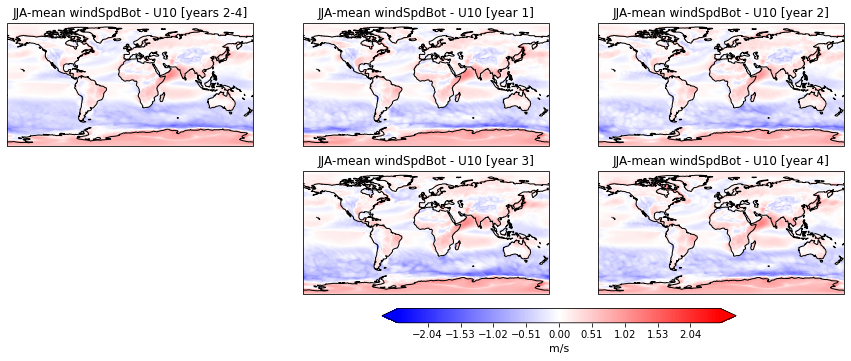

In [82]:
fig,axs = plt.subplots(2,3, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()
fig.delaxes(axs[3])

levsMap = np.arange(-2.5,2.51,0.01)

axs[0].set_title('JJA-mean windSpdBot - U10 [years 2-4]')
axs[0].contourf(yrs2to4_h1.lon.values, yrs2to4_h1.lat.values, 
                yrs2to4_h1.windSpeedBot_minU10.mean(dim='time').values,
                levsMap, cmap='bwr',extend='both')

axs[1].set_title('JJA-mean windSpdBot - U10 [year 1]')
axs[1].contourf(yr1_h1.lon.values, yr1_h1.lat.values, 
                yr1_h1.windSpeedBot_minU10.mean(dim='time').values,
                levsMap, cmap='bwr',extend='both')

axs[2].set_title('JJA-mean windSpdBot - U10 [year 2]')
axs[2].contourf(yr2_h1.lon.values, yr2_h1.lat.values, 
                yr2_h1.windSpeedBot_minU10.mean(dim='time').values,
                levsMap, cmap='bwr',extend='both')

axs[4].set_title('JJA-mean windSpdBot - U10 [year 3]')
axs[4].contourf(yr3_h1.lon.values, yr3_h1.lat.values, 
                yr3_h1.windSpeedBot_minU10.mean(dim='time').values,
                levsMap, cmap='bwr',extend='both')

axs[5].set_title('JJA-mean windSpdBot - U10 [year 4]')
p5 = axs[5].contourf(yr4_h1.lon.values, yr4_h1.lat.values, 
                yr4_h1.windSpeedBot_minU10.mean(dim='time').values,
                levsMap, cmap='bwr',extend='both')

## Add colorbar
ax_position = axs[5].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.1, 0.04])
cbar        = plt.colorbar(p5, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L58fv_cam6_h1['windSpeedBot_minU10'].units,fontsize=11)

axs[0].coastlines()
axs[1].coastlines()
axs[2].coastlines()
axs[4].coastlines()
axs[5].coastlines()
